In [1]:
suppressMessages(library(RSkittleBrewer))
suppressMessages(library(genefilter))
suppressMessages(library(devtools))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(ggplot2))
suppressMessages(library(DESeq2))
suppressMessages(library(calibrate))
suppressMessages(library(stringr))
suppressMessages(library(ggrepel))
suppressMessages(library(cluster))
suppressMessages(library(Biobase))
suppressMessages(library(qvalue))
suppressMessages(library(EBSeq))
suppressMessages(library(Rsamtools))
suppressMessages(library(GenomicFeatures))
suppressMessages(library(GenomicAlignments))
suppressMessages(library(tximport))
suppressMessages(library(readr))
suppressMessages(library(tximportData))
suppressMessages(library(apeglm))
suppressMessages(library(knitr))
suppressMessages(library(IHW))
suppressMessages(library(ashr))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(AnnotationDbi))
suppressMessages(library(ReportingTools))
suppressMessages(library(regionReport))
suppressMessages(library(Glimma))
suppressMessages(library(pcaExplorer))
suppressMessages(library(DEVis))
suppressMessages(library(vsn))
suppressMessages(library(repr))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(glmpca))
suppressMessages(library(Gviz))
suppressMessages(library(TxDb.Hsapiens.UCSC.hg38.knownGene))
suppressMessages(library(ensembldb))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(tximeta))
suppressMessages(library(GenomicRanges))
suppressMessages(library(biovizBase))
suppressMessages(library(ggbio))
suppressMessages(library(karyoploteR))
suppressMessages(library(gplots))
suppressMessages(library(dplyr))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(PCAtools))
suppressMessages(library(sva))
suppressMessages(library(DRIMSeq))
suppressMessages(library(biomaRt))
suppressMessages(library(grid))
suppressMessages(library(PoiClaClu))
suppressMessages(library(rnaseqDTU))
suppressMessages(library(BiocParallel))
suppressMessages(library(stageR))
suppressMessages(library(DEXSeq))
suppressMessages(library(DEGreport))

In [2]:
register(MulticoreParam(35))

In [3]:
# suppress warning messages
options(warn=-1)

In [4]:
# disable scientific notation
options(scipen=999)

# SALMONTE

In [5]:
getwd()

[1] "/mnt/nfs/shared/999993-Bioda/projects/kaja_transposons/RNA_SEQ/KPSP_MIX1+2"

In [5]:
# function to store heatmaps as png
save_pheatmap_png <- function(x, filename, width=580, height=480) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   invisible(dev.off())
}

In [6]:
salmonTE_samples <- read.table(file.path("SALMONTE_IN", 
                                         "salmonTE_samples.txt"), 
                               header = FALSE)
files <- file.path("SALMONTE_IN", 
                   paste0(salmonTE_samples$V1, 
                          "/",  
                          "quant.sf"))
condition = factor(rep(c('control', 'cth'), each = 8))
coldata <- data.frame(files, 
                      names=paste0(c(as.vector(salmonTE_samples$V1))), 
                      condition=condition, 
                      stringsAsFactors=FALSE)
suppressMessages(se <- tximeta(coldata, 
                               countsFromAbundance = "no"))
se

class: SummarizedExperiment 
dim: 687 16 
metadata(3): tximetaInfo quantInfo countsFromAbundance
assays(3): counts abundance length
rownames(687): ALU AluJb ... X6B_LINE X8_LINE
rowData names(0):
colnames(16): RNA01 RNA02 ... RNA15 RNA16
colData names(2): names condition

In [9]:
head(assays(se)$counts)

,RNA01,RNA02,RNA03,RNA04,RNA05,RNA06,RNA07,RNA08,RNA09,RNA10,RNA11,RNA12,RNA13,RNA14,RNA15,RNA16
ALU,3240.460,3692.130,2338.840,3063.69,2948.710,3016.540,4934.880,3889.1600,4058.250,3203.550,1404.0100,3389.07,2413.88,2608.990,2594.130,2435.600
AluJb,11654.700,10060.000,8853.940,12250.00,10838.900,11847.900,18780.500,10400.6000,15377.000,12972.200,4147.3300,12920.00,11146.00,10214.600,9679.940,8456.500
AluJo,1644.790,123.765,1159.140,1649.92,1295.900,1417.650,2541.150,59.3661,1806.110,1438.560,68.1817,1761.18,1358.01,1219.200,1163.460,812.287
AluJr,613.827,556.110,454.999,539.98,540.169,554.846,739.716,322.3760,602.964,571.814,209.7110,536.86,589.56,475.091,384.753,441.331
AluJr4,2987.260,2463.930,2310.740,2887.12,3088.160,2933.250,5365.250,2713.1500,3573.670,3381.990,1043.4600,3103.36,2672.33,2585.510,2527.430,2014.300
AluSc,32424.700,31237.200,27344.600,35236.90,31544.800,33106.700,54359.600,27891.4000,43306.700,38893.600,14302.9000,36893.40,35017.00,29823.600,28812.300,26717.200


In [10]:
# determine the mean-variance curve for CONTROL samples
mean_counts <- apply(assays(se)$counts[,1:8], 1, mean)
variance_counts <- apply(assays(se)$counts[,1:8], 1, var)
mean_var_df <- data.frame(mean_counts, variance_counts)

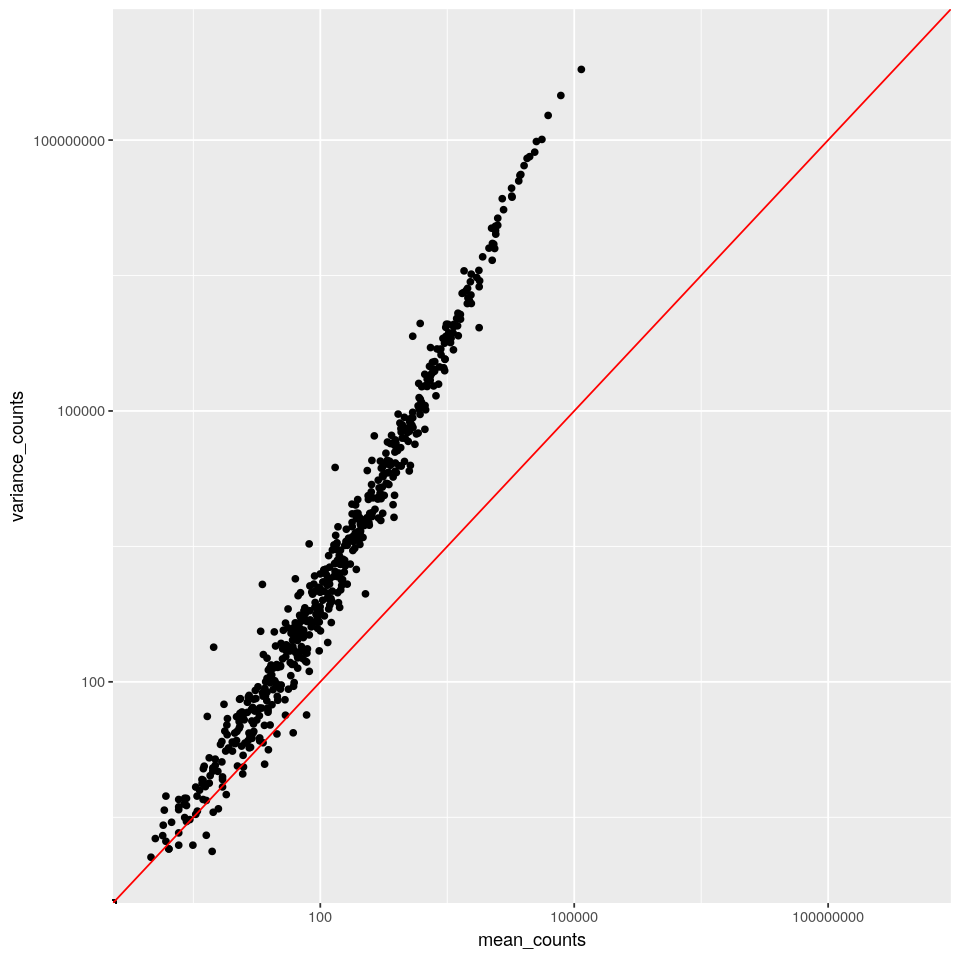

In [80]:
# mean versus variance for CONTROL replicates
# --> variance > mean
# --> need to account for this increase in variance using the Negative Binomial model
ggplot(mean_var_df) +
        geom_point(aes(x=mean_counts, y=variance_counts)) + 
        scale_y_log10(limits = c(1,1e9)) +
        scale_x_log10(limits = c(1,1e9)) +
        geom_abline(intercept = 0, slope = 1, color="red")

In [81]:
# determine the mean-variance curve for TEST samples
mean_counts <- apply(assays(se)$counts[,9:16], 1, mean)
variance_counts <- apply(assays(se)$counts[,9:16], 1, var)
mean_var_df <- data.frame(mean_counts, variance_counts)

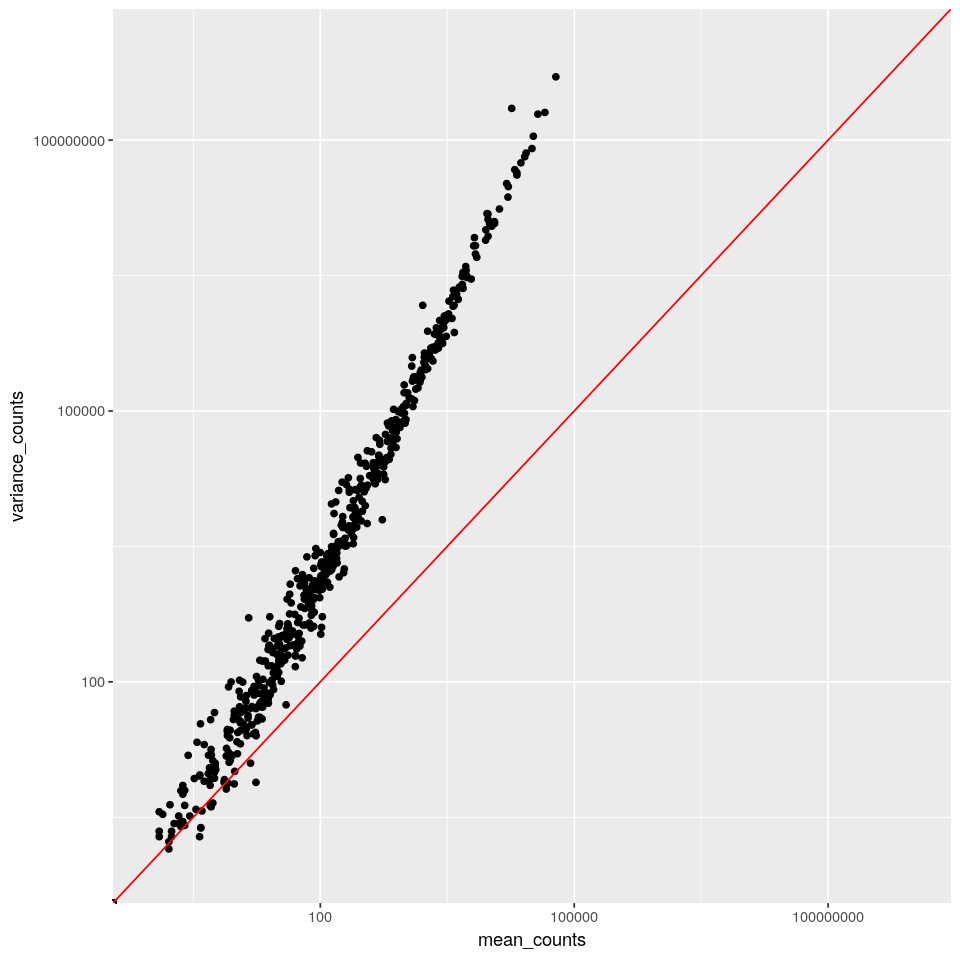

In [82]:
# mean versus variance for TEST replicates
# --> variance > mean
# --> need to account for this increase in variance using the Negative Binomial model
ggplot(mean_var_df) +
        geom_point(aes(x=mean_counts, y=variance_counts)) + 
        scale_y_log10(limits = c(1,1e9)) +
        scale_x_log10(limits = c(1,1e9)) +
        geom_abline(intercept = 0, slope = 1, color="red")

In [83]:
# The value of additional replicates is that as you add more data (replicates), 
# you get increasingly precise estimates of group means, 
# and ultimately greater confidence in the ability 
# to distinguish differences between sample classes (i.e. more DE genes).

In [84]:
# DESeq2 / edgeR -> ok for small sample sizes
# Limma-voom -> only from 20 replicates per group (less sensitive)

In [11]:
# transform SummarizedExperiment into a DESeqDataSet
suppressMessages(ddsS <- DESeqDataSet(se, 
                                      design=~condition))
# Pre-filtering
# at least x counts in y samples
# keep <- rowSums(counts(ddsS) >= 5 ) >= 16
keep <- rowSums(counts(ddsS)) > 8
ddsSE <- ddsS[keep,]
ddsSE

class: DESeqDataSet 
dim: 589 16 
metadata(4): tximetaInfo quantInfo countsFromAbundance version
assays(3): counts abundance avgTxLength
rownames(589): ALU AluJb ... X5B_LINE X6B_LINE
rowData names(0):
colnames(16): RNA01 RNA02 ... RNA15 RNA16
colData names(2): names condition

In [12]:
# Run DESeq2 on DESeqDataSet
# --> performs default analysis:
# 1) estimation of size factors: estimateSizeFactors
# 2) estimation of dispersion: estimateDispersions
# 3) Negative Binomial GLM fitting and Wald statistics: nbinomWaldTest
suppressMessages(ddsSE <- DESeq(ddsSE))
ddsSE

class: DESeqDataSet 
dim: 589 16 
metadata(4): tximetaInfo quantInfo countsFromAbundance version
assays(9): counts abundance ... replaceCounts replaceCooks
rownames(589): ALU AluJb ... X5B_LINE X6B_LINE
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(16): RNA01 RNA02 ... RNA15 RNA16
colData names(3): names condition replaceable

In [13]:
resultsNames(ddsSE)

[1] "Intercept"                "condition_cth_vs_control"

In [14]:
sizeFactors(ddsSE)

NULL

In [15]:
counts_df <- as.data.frame(counts(ddsSE, normalized=TRUE), 
                           stringsAsFactors=F)

In [16]:
head(counts_df)

,RNA01,RNA02,RNA03,RNA04,RNA05,RNA06,RNA07,RNA08,RNA09,RNA10,RNA11,RNA12,RNA13,RNA14,RNA15,RNA16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALU,2562.6035,3744.2834,2510.8296,2598.5991,3146.1622,2877.4250,2984.7536,3946.55909,2899.8319,2875.5234,3671.8356,3141.5734,2363.3416,2618.8994,2852.1293,3179.4290
AluJb,9218.8565,10203.2724,9505.3305,10390.9562,11563.2279,11299.9551,11357.8140,10553.80107,10986.7621,11641.8212,10845.4136,11975.6086,10913.6928,10253.4846,10642.2810,11037.0406
AluJo,1301.1599,125.7660,1244.2600,1399.5982,1382.5946,1352.4085,1536.7522,59.86677,1290.3747,1291.4416,177.8365,1632.2792,1329.6963,1223.5925,1278.6129,1059.8483
AluJr,485.7585,564.0473,488.5669,458.2043,576.0642,529.3697,447.4802,326.67110,430.7184,513.3199,549.1203,497.5544,577.8758,476.7926,423.1775,575.6583
AluJr4,2363.1279,2499.6627,2481.4904,2449.6961,3294.2339,2797.5520,3244.2313,2752.35621,2552.8814,3035.0489,2727.2974,2875.0677,2617.0917,2595.7591,2777.5831,2628.9701
AluSc,25642.8851,31673.2791,29347.3570,29875.0131,33657.0466,31573.9842,32878.1853,28313.99477,30953.8273,34907.9572,37410.5868,34204.6967,34271.6378,29940.9077,31682.0268,34870.2105


In [31]:
# export count table
write.csv(counts_df, 
            file = "SALMONTE_RES/SalmonTE_CountTable_NORM_SCALED.txt", 
            row.names = T, 
            quote = F)

In [17]:
head(counts(ddsSE))
# counts(ddsSE) <- counts(ddsSE, normalized=TRUE)

,RNA01,RNA02,RNA03,RNA04,RNA05,RNA06,RNA07,RNA08,RNA09,RNA10,RNA11,RNA12,RNA13,RNA14,RNA15,RNA16
ALU,3240,3692,2339,3064,2949,3017,4935,3889,4058,3204,1404,3389,2414,2609,2594,2436
AluJb,11655,10060,8854,12250,10839,11848,18780,10401,15377,12972,4147,12920,11146,10215,9680,8456
AluJo,1645,124,1159,1650,1296,1418,2541,59,1806,1439,68,1761,1358,1219,1163,812
AluJr,614,556,455,540,540,555,740,322,603,572,210,537,590,475,385,441
AluJr4,2987,2464,2311,2887,3088,2933,5365,2713,3574,3382,1043,3103,2672,2586,2527,2014
AluSc,32425,31237,27345,35237,31545,33107,54360,27891,43307,38894,14303,36893,35017,29824,28812,26717


In [18]:
# lists the coefficients
resultsNames(ddsSE)

[1] "Intercept"                "condition_cth_vs_control"

In [14]:
design <- model.matrix(~0+condition)
colnames(design) <- c("control","cth")
contrast <- makeContrasts(cth-control, 
                          levels = design)

In [15]:
contrast

,cth - control
control,-1
cth,1


In [19]:
res_se <- DESeq2::results(ddsSE)

In [20]:
colnames(res_se)

[1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
[5] "pvalue"         "padj"

In [21]:
res_se_ord <- res_se[ order(res_se$padj, decreasing = FALSE), ]

In [22]:
# save results
write.csv(res_se_ord, 
            file = "SALMONTE_RES/salmonTE_results.txt", 
            row.names = T, 
            quote = F)

In [24]:
# variance stabilizing transformation (VST) 
# for negative binomial data with a dispersion-mean trend
vsd_se <- varianceStabilizingTransformation(ddsSE, 
                                            blind = FALSE)

In [25]:
# RLOG = regularized-logarithm transformation
# with high counts, rlog transformation is similar to log2
# with low counts, values are shrunken towards the transcripts' averages across all samples
# --> avoids low counts to dominate due to strong Poisson noise
# --> rlog-transformed data are approximately homoskedastic
# --> for exploratory analysis, not differential analysis
rld_se <- rlog(ddsSE, 
               blind = FALSE)

In [26]:
# Samples distance before RLOG
# --> calculate the Euclidean distance between samples
# using rlog-transofrmed data to avoid that the distance measure
# is dominated by a few highly variable genes
# --> function t to transpose the data matrix
sampleDists <- dist(t(assay(ddsSE)))

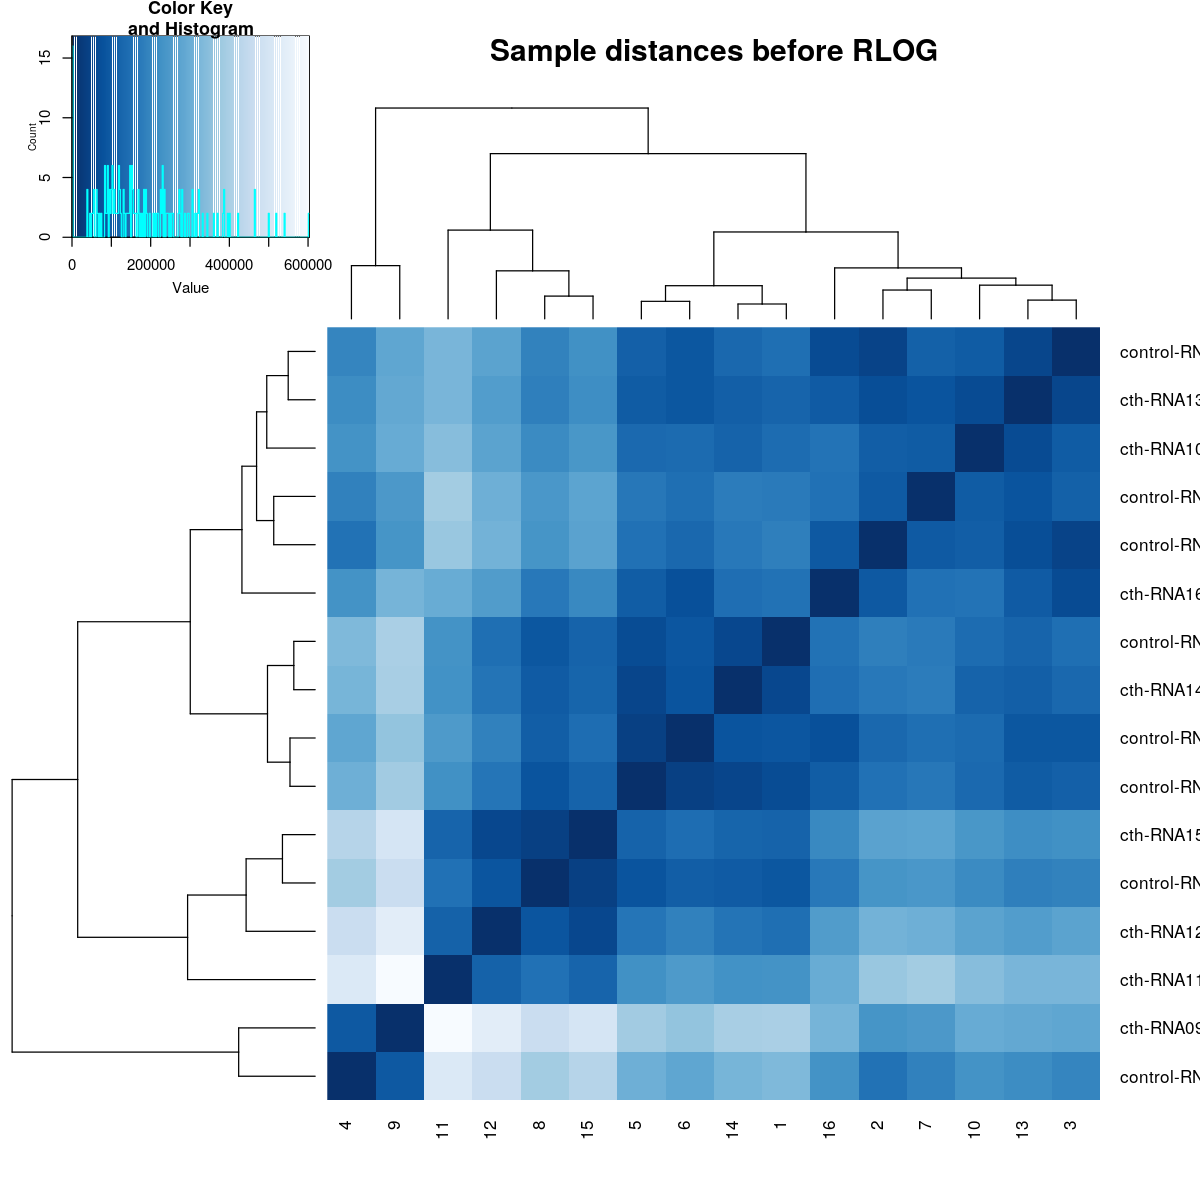

In [181]:
# Log2 sample distance matrix
options(repr.plot.width=10, repr.plot.height=10)
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld_se$condition, 
                                    rld_se$names, 
                                    sep="-")
colnames(sampleDistMatrix) <- NULL
colours = colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
heatmap.2(sampleDistMatrix, 
          trace="none", 
          col=colours, 
          main="Sample distances before RLOG")
invisible(dev.print(png, 
                    "SALMONTE_RES/SalmonTE_heatmap_euclid_distance_LOG2.png", 
                    width=480, 
                    height=480))

In [182]:
# Samples distance after RLOG
# --> calculate the Euclidean distance between samples
# using rlog-transofrmed data to avoid that the distance measure
# is dominated by a few highly variable genes
# --> function t to transpose the data matrix
sampleDists <- dist(t(assay(rld_se)))

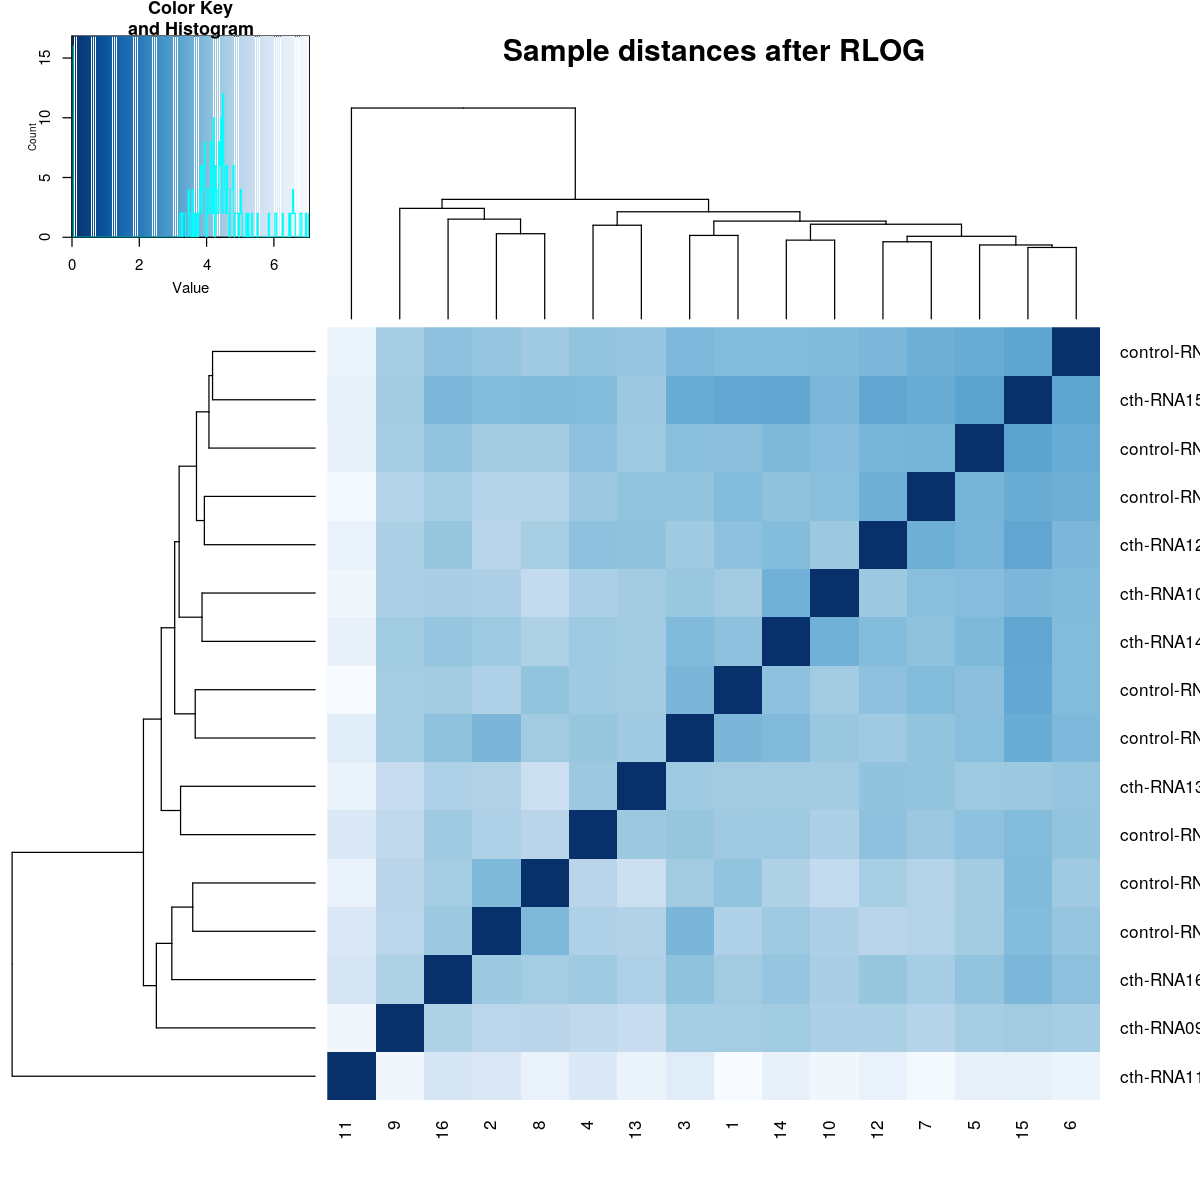

In [183]:
# RLOG sample distance matrix
options(repr.plot.width=10, 
        repr.plot.height=10)
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld_se$condition, 
                                    rld_se$names, 
                                    sep="-")
colnames(sampleDistMatrix) <- NULL
colours = colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
heatmap.2(sampleDistMatrix, 
          trace="none", 
          col=colours, 
          main="Sample distances after RLOG")
invisible(dev.print(png, 
                    "SALMONTE_RES/SalmonTE_heatmap_euclid_distance_RLOG.png", 
                    width=480, 
                    height=480))

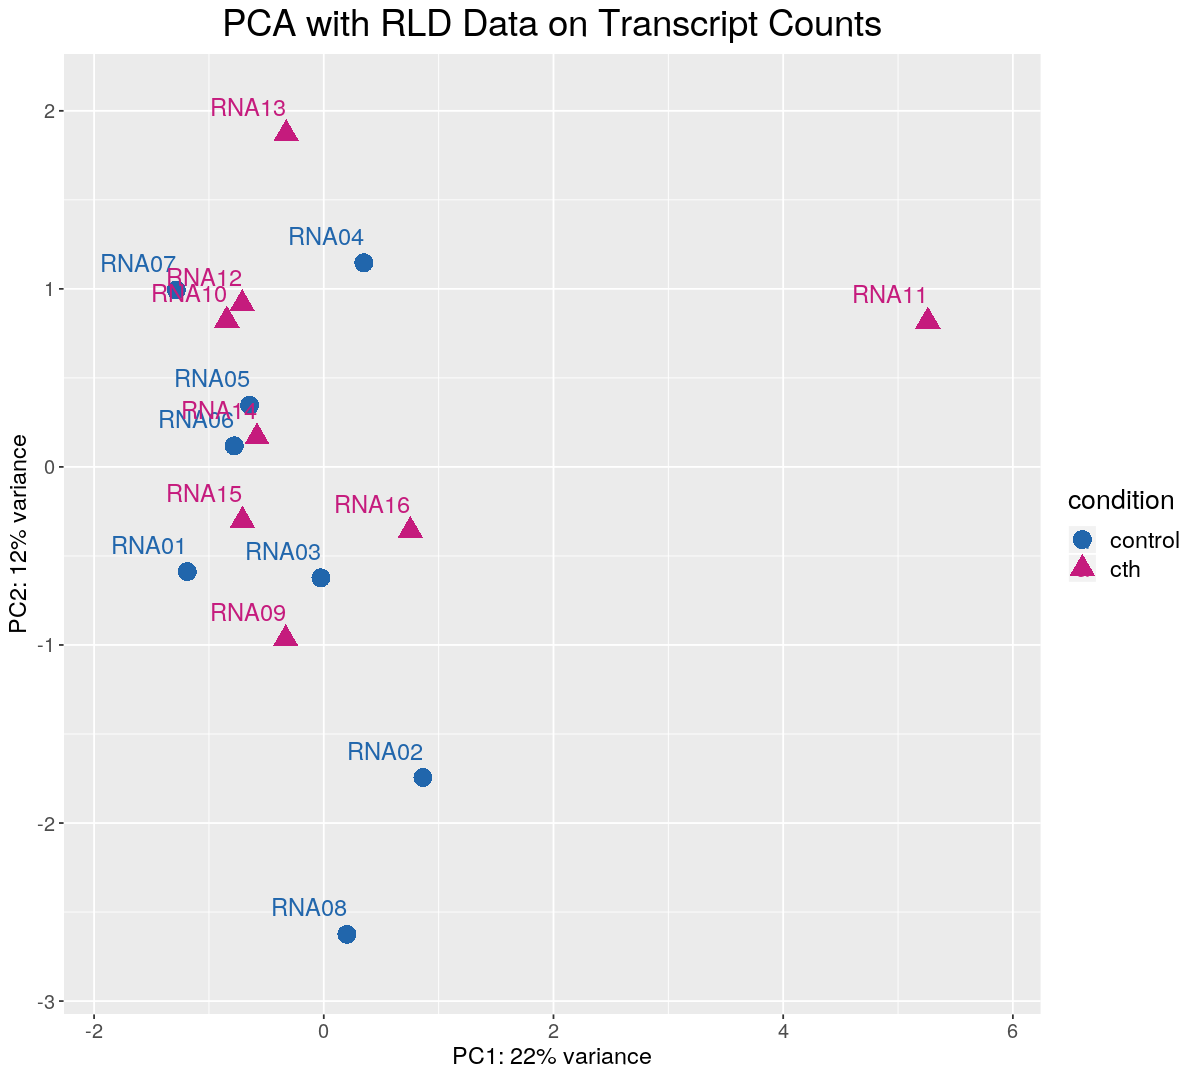

In [184]:
# RLOG PCA
pcaData <- DESeq2::plotPCA(rld_se, intgroup = c( "names", "condition"), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(pcaData, aes(x = PC1, y = PC2, color=condition, shape=condition)) +
geom_point(size =5) +
geom_text(aes(label=name),hjust=1, vjust=-1, cex=5) +
xlab(paste0("PC1: ", percentVar[1], "% variance")) +
ylab(paste0("PC2: ", percentVar[2], "% variance")) +
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
ggtitle("PCA with RLD Data on Transcript Counts") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("SALMONTE_RES/SalmonTE_TXIMETA_PCA_RLD_transcripts.png", width=10, height=9)

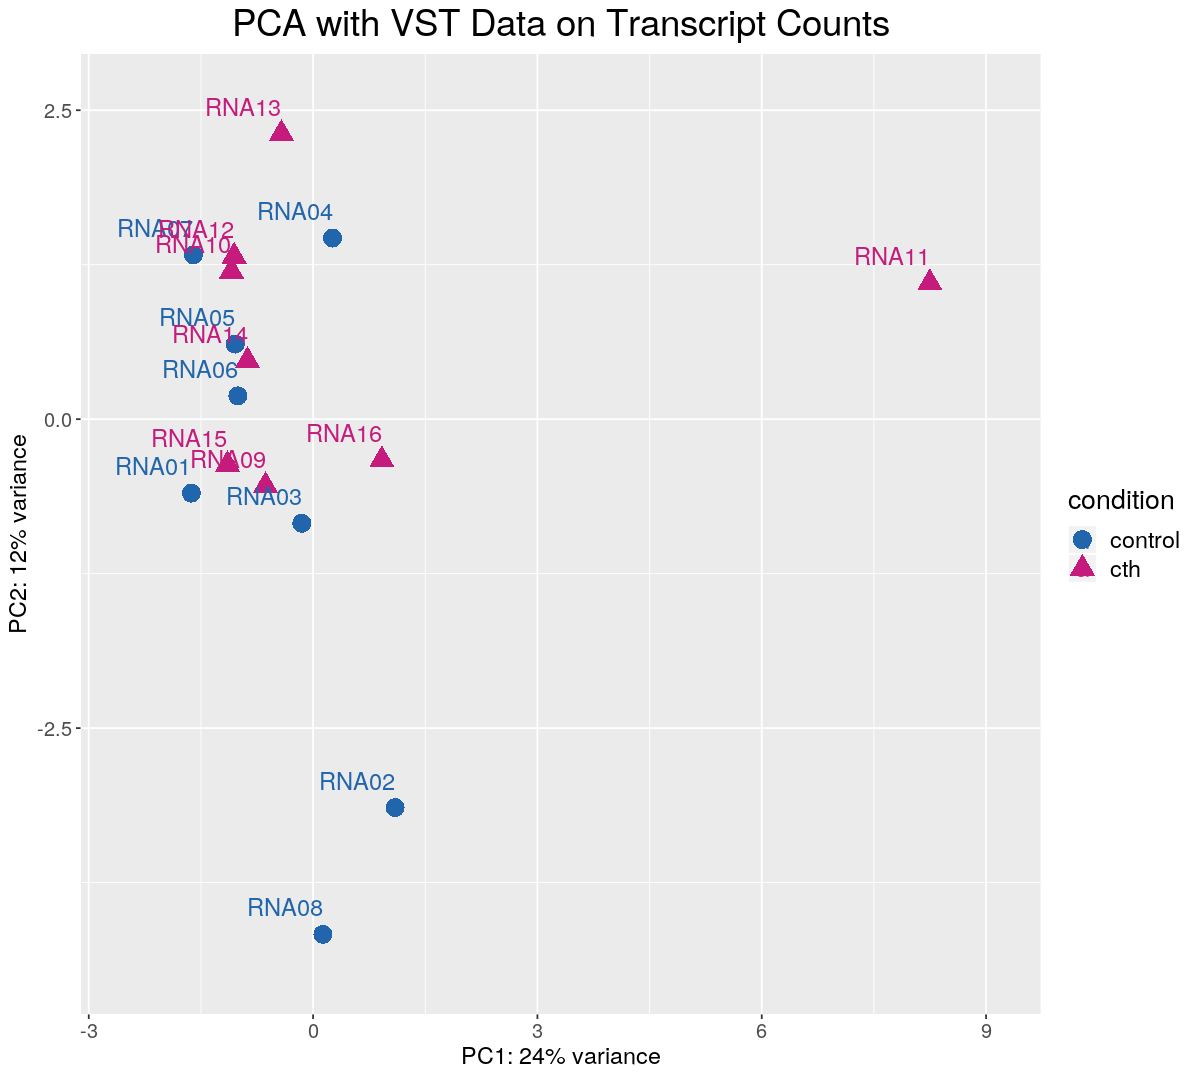

In [185]:
# VST PCA
pcaData <- DESeq2::plotPCA(vsd_se, intgroup = c( "names", "condition"), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(pcaData, aes(x = PC1, y = PC2, color=condition, shape=condition)) +
geom_point(size =5) +
geom_text(aes(label=name),hjust=1, vjust=-1, cex=5) +
xlab(paste0("PC1: ", percentVar[1], "% variance")) +
ylab(paste0("PC2: ", percentVar[2], "% variance")) +
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
ggtitle("PCA with VST Data on Transcript Counts") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("SALMONTE_RES/SalmonTE_TXIMETA_PCA_VST_transcripts.png", width=10, height=9)

In [38]:
# subset of the 20 most highly variable genes from VST data
topVarTx <- head(which(res_se$pvalue < 0.05),decreasing = FALSE, 50)
#topVarTx <- head(order(rowVars(assay(vsd_se)), decreasing = FALSE), 20)
mat  <- assay(vsd_se)[topVarTx,]
#mat  <- mat - rowMeans(mat)
mat

,RNA01,RNA02,RNA03,RNA04,RNA05,RNA06,RNA07,RNA08,RNA09,RNA10,RNA11,RNA12,RNA13,RNA14,RNA15,RNA16
AluSc,14.651714,14.955387,14.845700,14.871325,15.042770,14.950871,15.009091,14.794158,14.922341,15.095269,15.194893,15.065990,15.068803,14.874494,14.955785,15.093713
AluSq4,11.247622,11.425227,11.302657,11.407479,11.687722,11.508208,11.591760,11.380394,11.564004,11.700781,11.600823,11.702488,11.601802,11.451387,11.541835,11.593727
AluYa4,14.403953,14.580415,14.511284,14.533615,14.786792,14.649373,14.780692,14.424441,14.628724,14.851504,14.746579,14.852736,14.766304,14.646079,14.701794,14.655663
HERV1_I,8.976852,8.508987,8.946338,8.425041,8.768679,8.818258,8.696285,8.555586,8.193500,8.687326,8.253769,8.389523,8.453697,8.502799,8.712306,8.689545
HERVK13I,7.067411,6.726593,7.084418,7.074068,6.809892,6.914876,6.951692,6.712796,6.603522,6.715725,6.772265,6.762923,6.537024,6.773620,7.044721,6.772727
HERVK3I,10.318050,10.429283,10.325156,9.970931,10.368892,10.316948,11.247572,10.084081,10.287903,10.343350,9.564729,10.143756,9.599759,10.193452,10.273447,9.869606
L1M4B,9.708503,10.178026,10.039752,9.888956,9.943469,9.604795,9.636337,9.615975,9.837136,10.608492,10.967811,9.656599,10.122093,10.104744,9.705595,9.826768
L1MD1_5,7.553673,7.002667,7.054704,6.646949,7.278153,6.843780,7.660565,6.716253,8.498569,8.557875,7.325652,7.691174,7.502774,8.504565,7.544734,7.904784
L1ME3C_3end,6.686636,6.547300,6.528275,6.849498,6.538688,6.555073,6.481877,6.607750,6.619630,6.443106,6.529152,6.446529,6.281546,6.280488,6.374114,6.440798
L1ME3E_3end,6.939244,7.130452,7.311137,6.662947,6.993925,7.232345,7.155883,6.917166,7.315910,7.609313,7.681301,7.276225,6.942924,7.252609,6.794714,7.218965


In [ ]:
#select <- order(rowMeans(counts(ddsSE,normalized=TRUE)),
#                decreasing=TRUE)[1:20]

In [39]:
df <- as.data.frame(colData(ddsSE)['condition'])

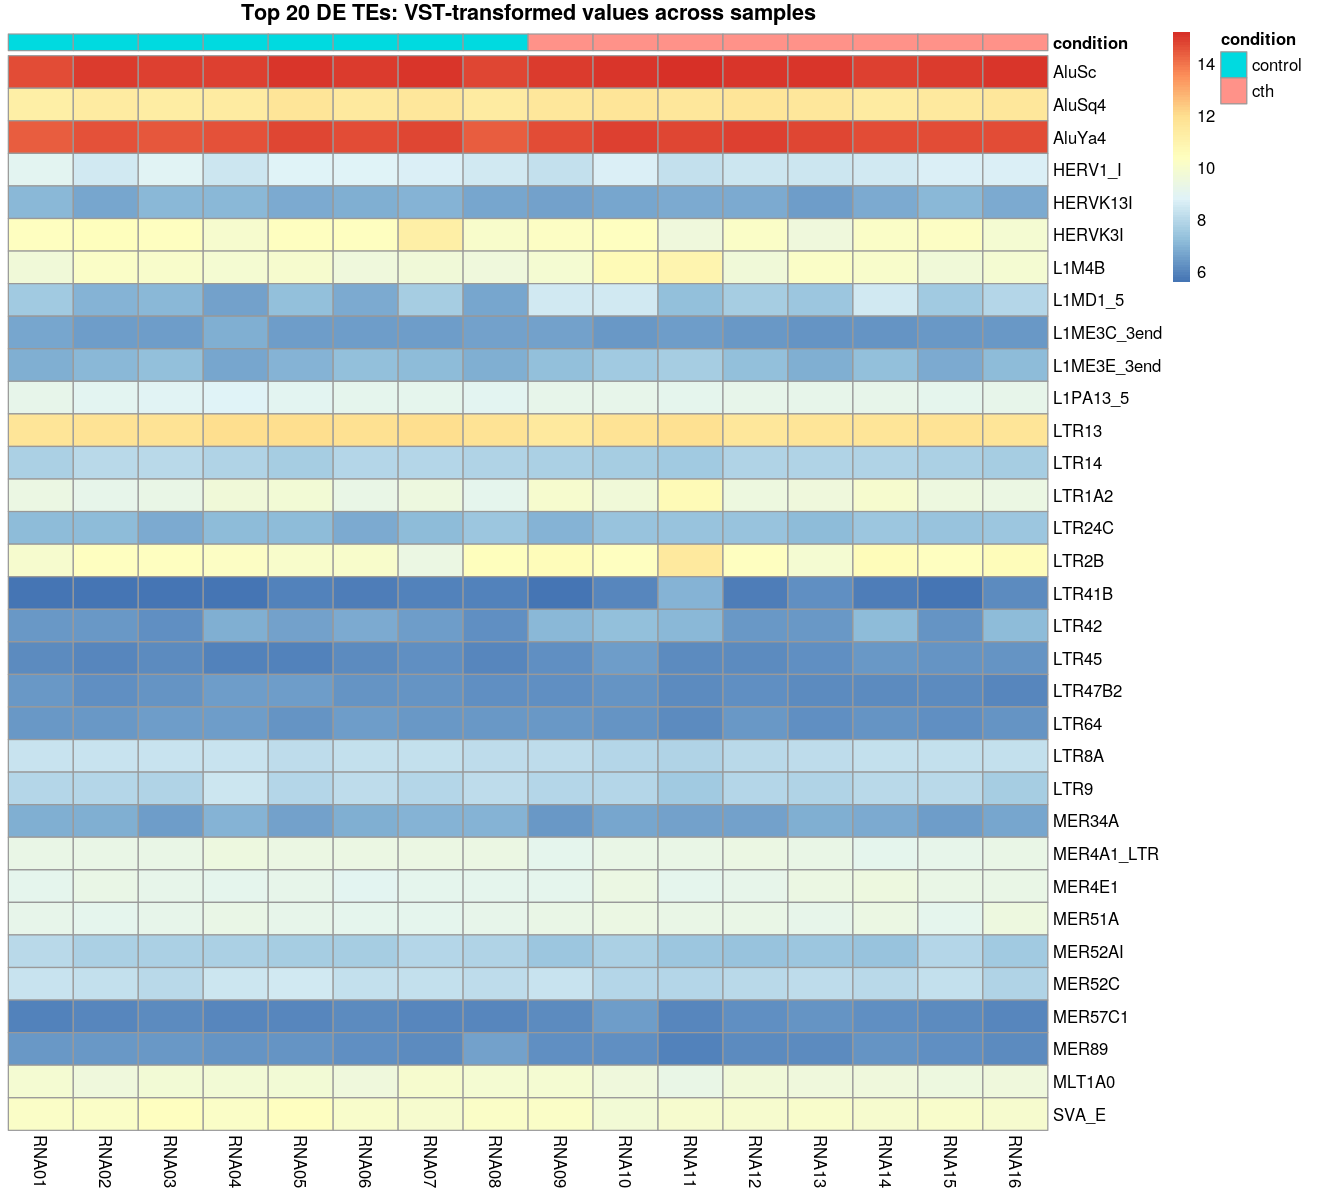

In [40]:
options(repr.plot.width=11, repr.plot.height=10)
pm = pheatmap(mat, 
              main="Top 20 DE TEs: VST-transformed values across samples",
              cluster_rows=FALSE,
              cluster_cols=FALSE,
              annotation_col=df)
save_pheatmap_png(pm, 
                  "SALMONTE_RES/SalmonTE_TXIMETA_heatmap_topDEte_VST.png")

In [189]:
# Genes with adjusted p-values less than 0.1
# padj: Benjamini-Hochberg (BH) adjustment
# if we consider a fraction of 10% false positives acceptable
# we can consider all genes with an adjusted p value below 10% (= 0.1) as significant
table(res_se$padj < 0.05)


FALSE  TRUE 
  577     1 

In [190]:
# most strongly up-regulated in C group
rownames(head(res_se[ order(res_se$log2FoldChange), ]))

[1] "X6B_LINE" "MIRb"     "L1M3B_5"  "LTR60B"   "LTR47B2"  "LTR38"

In [191]:
# most strongly up-regulated in T group
rownames(head(res_se[ order(res_se$log2FoldChange, decreasing = TRUE), ]))

[1] "LTR41B"  "L1MD1_5" "LTR42"   "LTR16A2" "MER57C1" "LTR45"

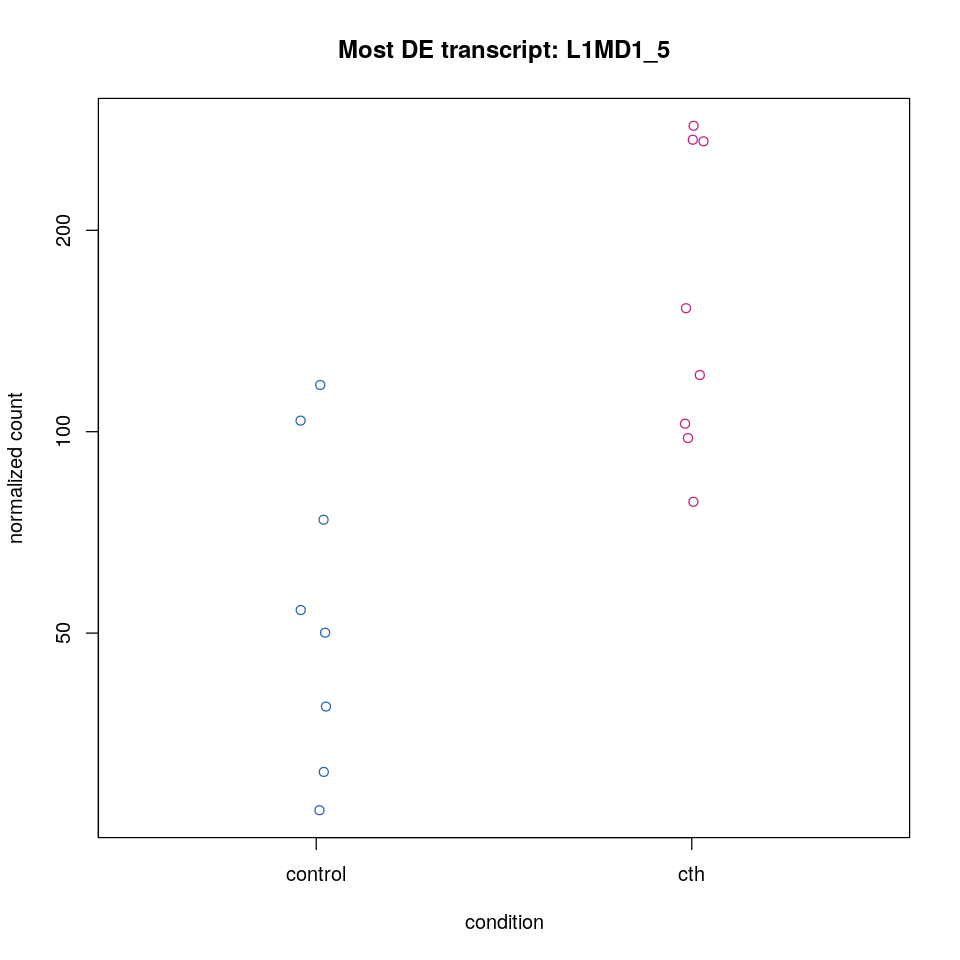

In [192]:
# retrieve the gene that has the lowest adjusted p value (= max differential expression)
# examine the counts of reads for this gene across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=8, repr.plot.height=8)
topGene <- rownames(ddsSE)[which.min(res_se$padj)]
plotCounts(ddsSE, 
           gene = topGene, 
           intgroup="condition", 
           col=col,
           main=paste0("Most DE transcript: ", topGene),
           xlab="condition")
invisible(dev.print(png, 
                    "SALMONTE_RES/SalmonTE_topDEtx_counts_TvsC.png", 
                    width=480, 
                    height=480))

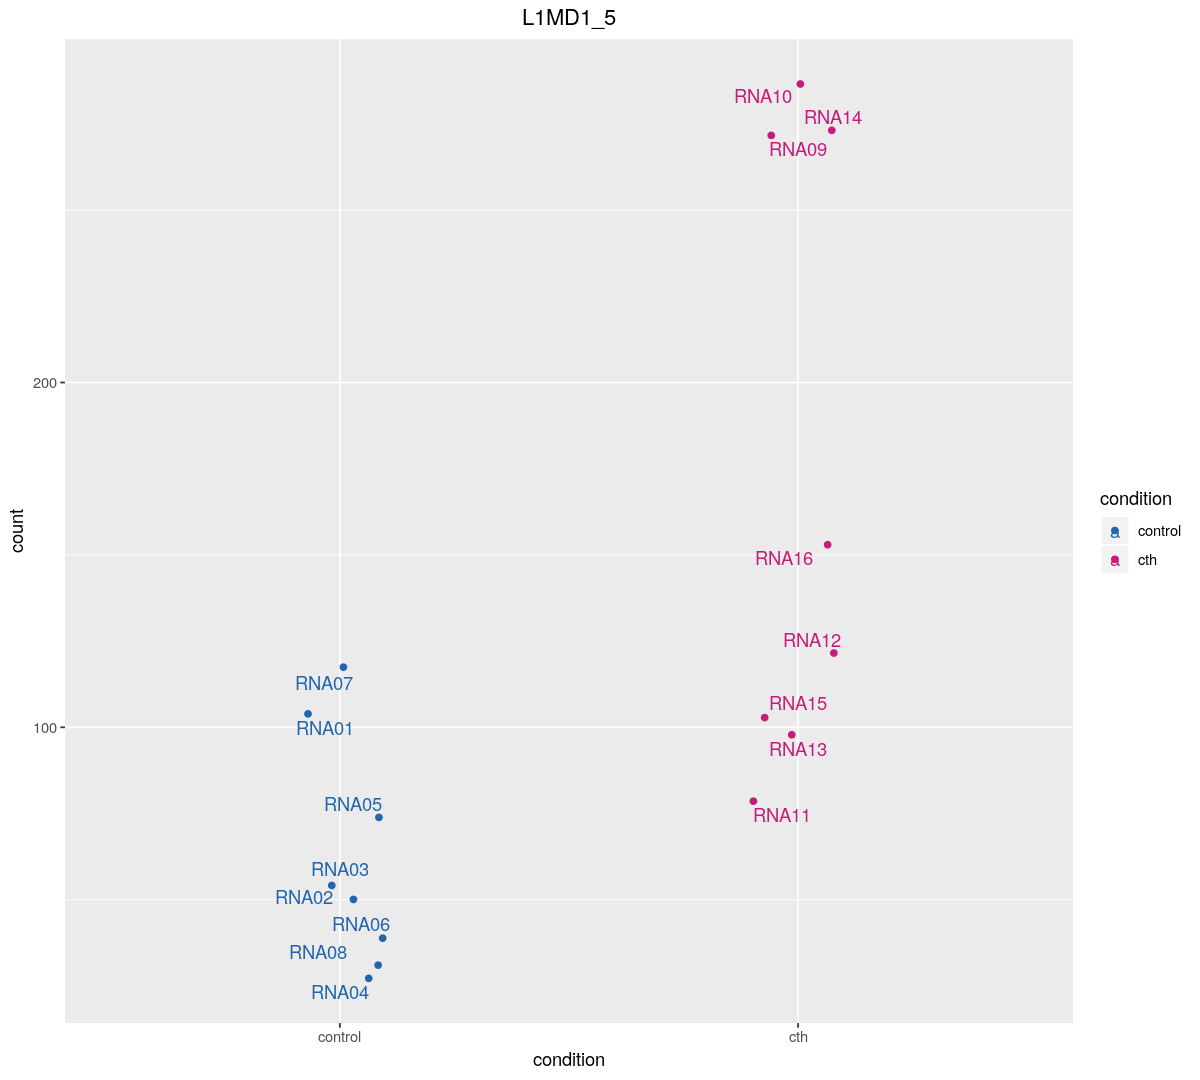

In [193]:
options(repr.plot.width=10, repr.plot.height=9)
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
d <- plotCounts(ddsSE, 
                gene=topGene, 
                intgroup="condition", 
                returnData=TRUE)
ggplot(d, 
       aes(x = condition, 
           y = count, 
           color = condition)) + 
geom_point(position=position_jitter(w = 0.1,h = 0)) +
geom_text_repel(aes(label = rownames(d))) + 
ggtitle(topGene) +
theme(plot.title = element_text(hjust = 0.5)) +
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))

In [194]:
# check raw counts of most DE tx
counts(ddsSE[which(rownames(ddsSE)==topGene)])

,RNA01,RNA02,RNA03,RNA04,RNA05,RNA06,RNA07,RNA08,RNA09,RNA10,RNA11,RNA12,RNA13,RNA14,RNA15,RNA16
L1MD1_5,129,48,49,31,69,40,194,31,387,319,30,134,97,273,93,117


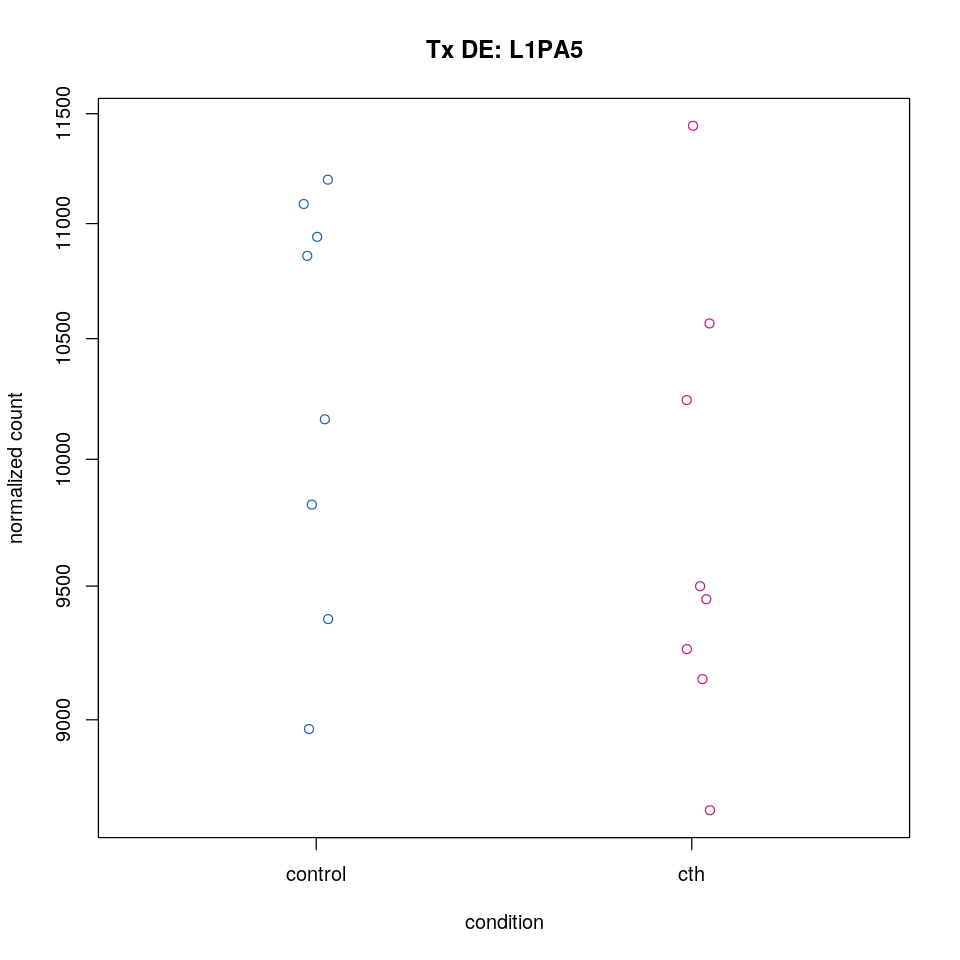

In [195]:
# examine the counts of reads for any TE across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], 
             brewer.pal(8, "PiYG")[1]), 
           each = 8)
options(repr.plot.width=8, 
        repr.plot.height=8)
plotCounts(ddsSE, 
           gene = "L1PA5", 
           intgroup=c("condition"), 
           col=col,
           main=paste0("Tx DE: ", "L1PA5"),
           xlab="condition")
invisible(dev.print(png, 
                    "SALMONTE_RES/SalmonTE_L1PA5_counts_CvsT.png", 
                    width=480, 
                    height=480))

In [196]:
# check raw counts of most DE tx
counts(ddsSE[which(rownames(ddsSE)=='L1PA5')])

,RNA01,RNA02,RNA03,RNA04,RNA05,RNA06,RNA07,RNA08,RNA09,RNA10,RNA11,RNA12,RNA13,RNA14,RNA15,RNA16
L1PA5,13657,10849,9926,10422,10428,10245,16856,9513,16319,10327,3334,10507,10539,9158,9311,7251


In [197]:
# shrinking fold2change with apeglm
apeglm_res <- lfcShrink(ddsSE, 
                        coef='condition_cth_vs_control',
                        type='apeglm',
                        res=res_se)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [203]:
colData(ddsSE)

DataFrame with 16 rows and 3 columns
            names condition replaceable
      <character>  <factor>   <logical>
RNA01       RNA01   control        TRUE
RNA02       RNA02   control        TRUE
RNA03       RNA03   control        TRUE
RNA04       RNA04   control        TRUE
RNA05       RNA05   control        TRUE
...           ...       ...         ...
RNA12       RNA12       cth        TRUE
RNA13       RNA13       cth        TRUE
RNA14       RNA14       cth        TRUE
RNA15       RNA15       cth        TRUE
RNA16       RNA16       cth        TRUE

No genes were mapped to rowData. check ann parameter values.

Using gene as id variables



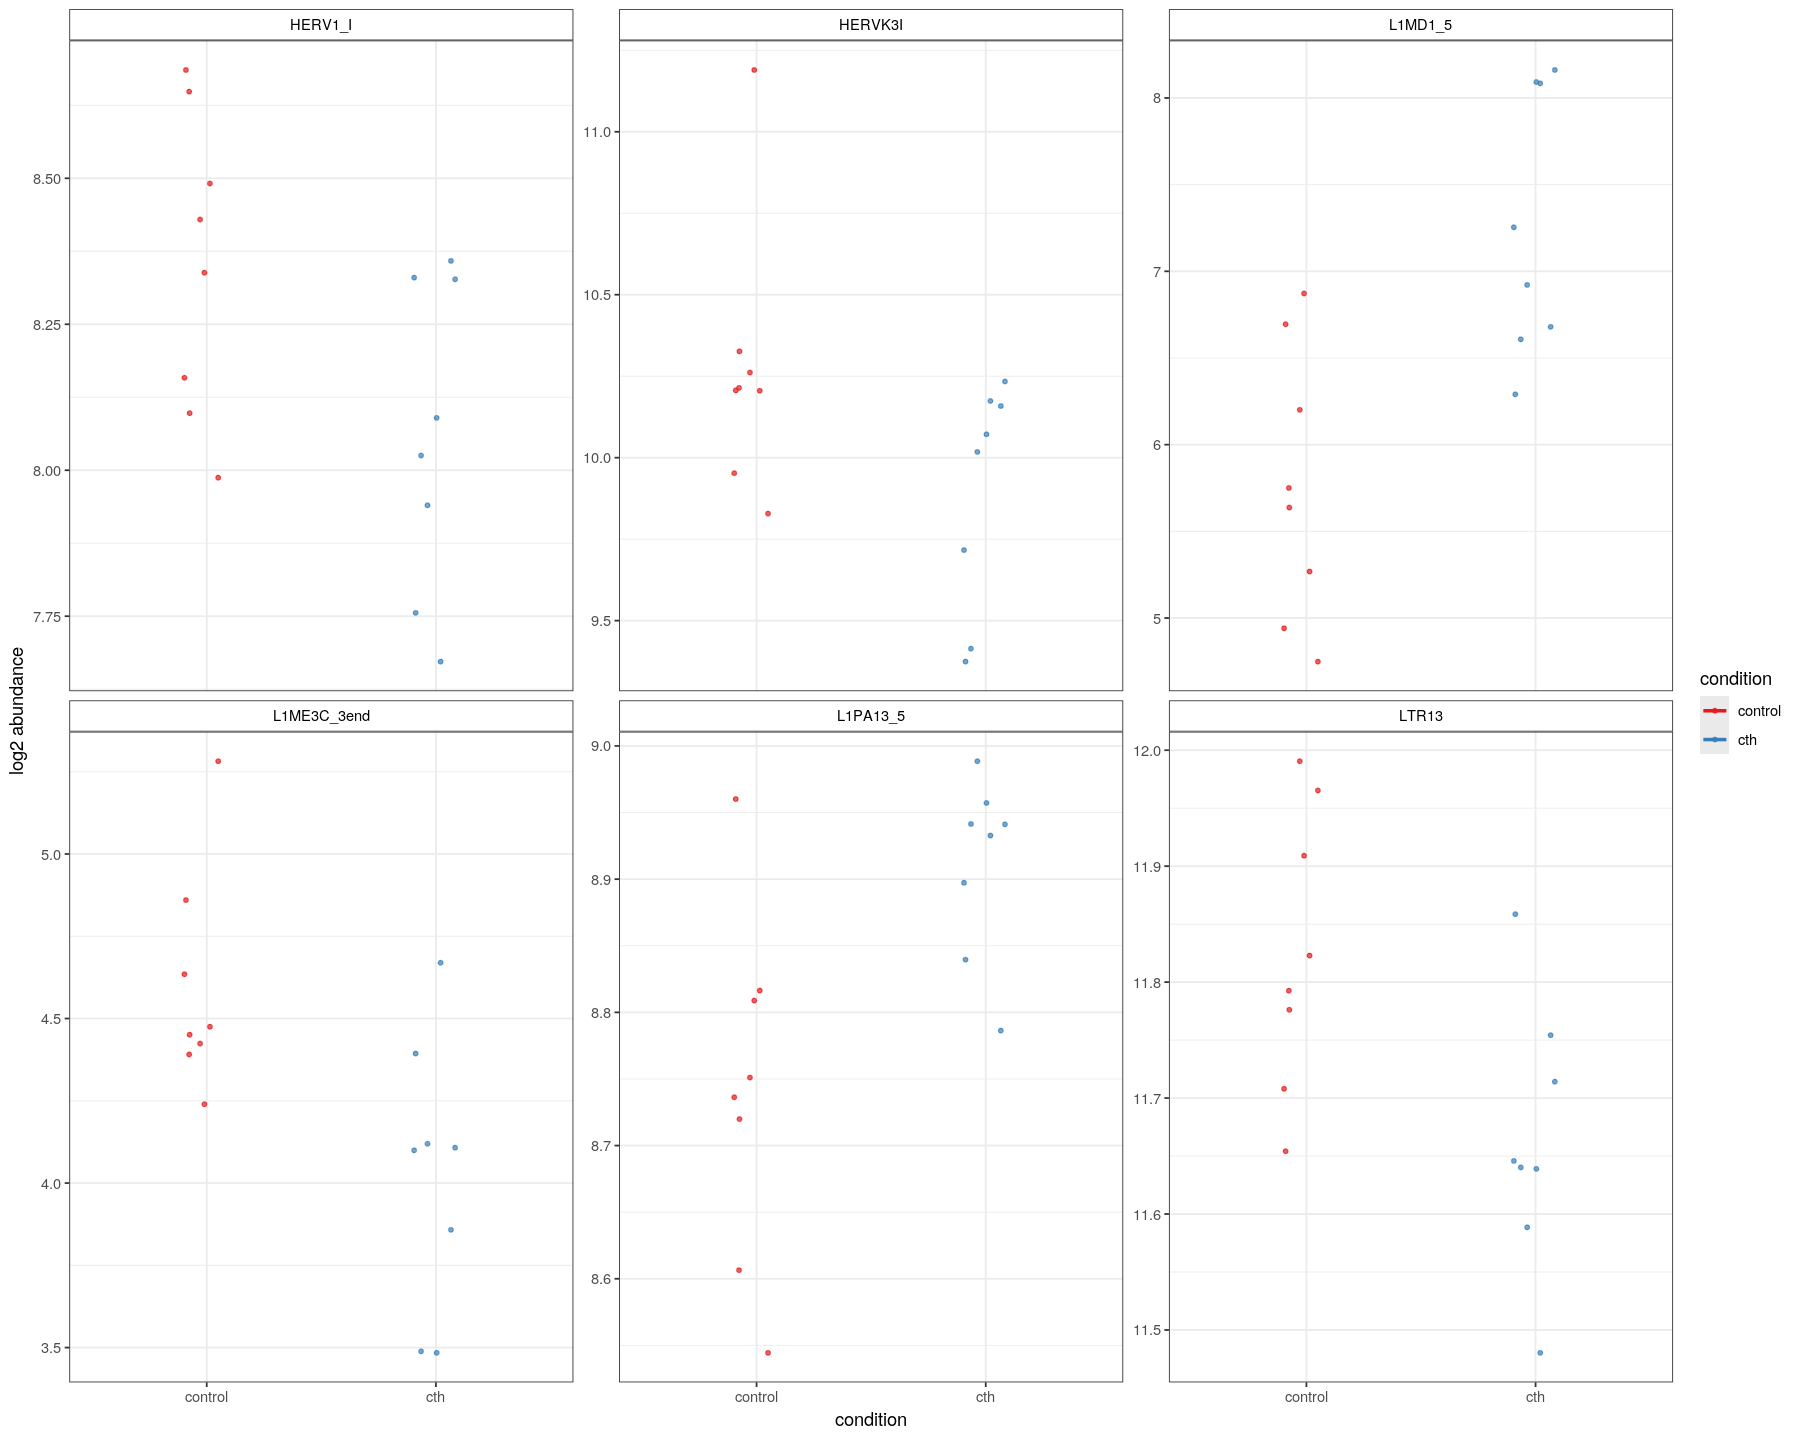

In [250]:
options(repr.plot.width=15, repr.plot.height=12)
DEGreport::degPlot(dds = ddsSE, 
                   res = apeglm_res, 
                   n = 6, 
                   xs = 'condition', 
                   group = "condition")

In [226]:
head(apeglm_res)

log2 fold change (MAP): condition cth vs control 
Wald test p-value: condition cth vs control 
DataFrame with 6 rows and 5 columns
               baseMean          log2FoldChange               lfcSE
              <numeric>               <numeric>           <numeric>
ALU    2998.36119296216  -0.0000082554814875127 0.00144257643134732
AluJb  10774.3323794509   0.0000226227231019584 0.00144235131265638
AluJo  1105.38051385151 0.000000508539488810523 0.00144269013102546
AluJr  495.023707421852  0.00000496702015803589 0.00144257050012703
AluJr4 2730.75312367102 -0.00000126753581389764 0.00144245259824155
AluSc  31950.2247543849     0.00100045952553657 0.00170198490264555
                   pvalue              padj
                <numeric>         <numeric>
ALU     0.659812400975807 0.996769248738091
AluJb   0.231726596794058 0.960399719215076
AluJo   0.793253154588597 0.996769248738091
AluJr   0.584824672206506 0.996769248738091
AluJr4  0.950211967854731 0.996769248738091
AluSc  0.03114225

In [230]:
apeglm_res$id <- rownames(apeglm_res)

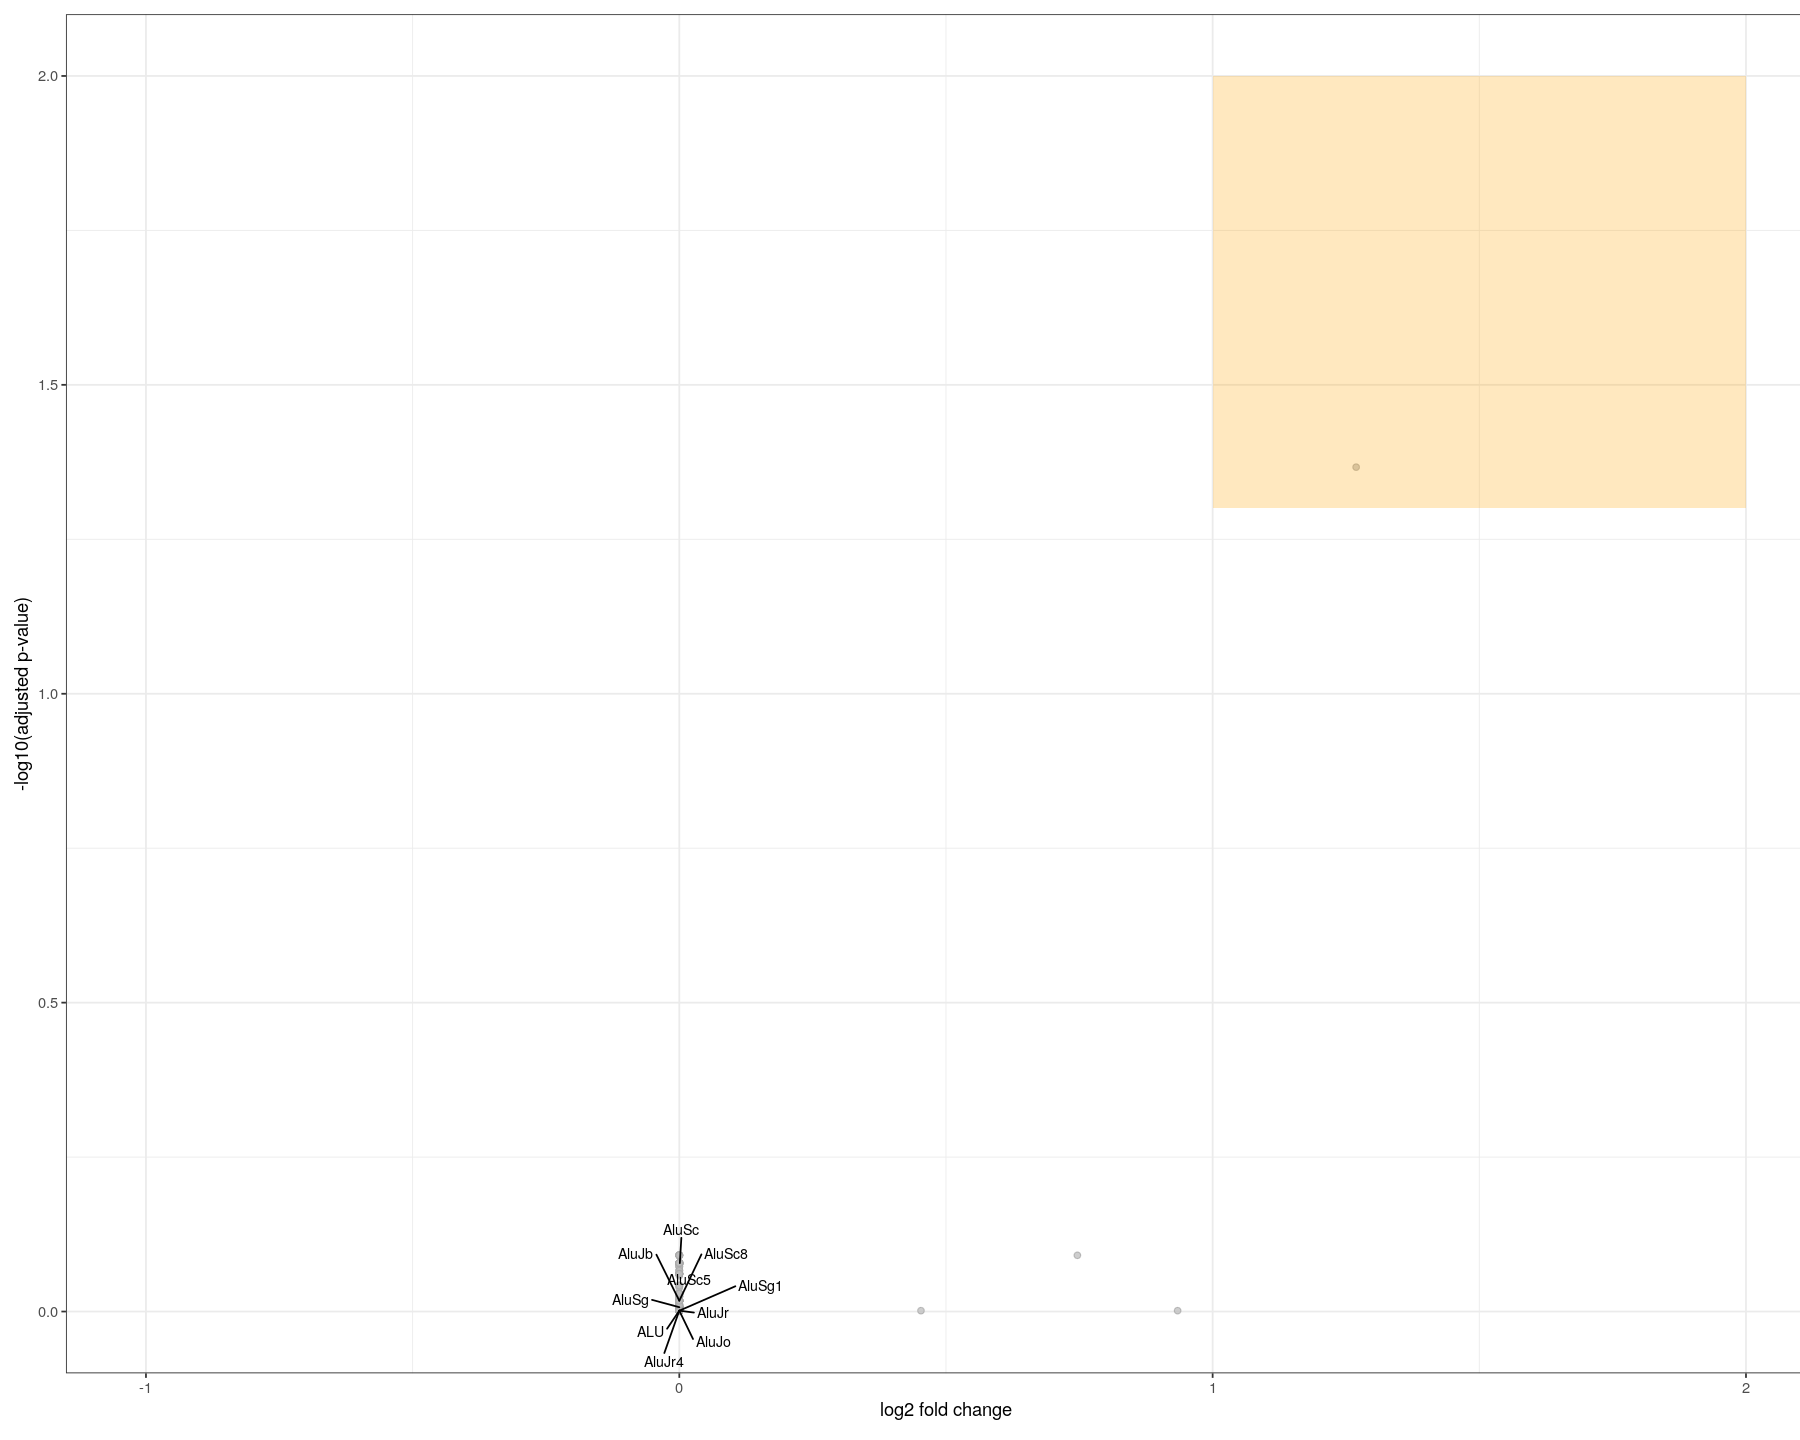

In [246]:
DEGreport::degVolcano(
    data.frame(apeglm_res[,c("log2FoldChange","padj")]), 
    plot_text = data.frame(apeglm_res[1:10,c("log2FoldChange","padj", "id")])) 

In [244]:
apeglm_res_ord <- apeglm_res[order(apeglm_res$padj, 
                                   decreasing = FALSE),]

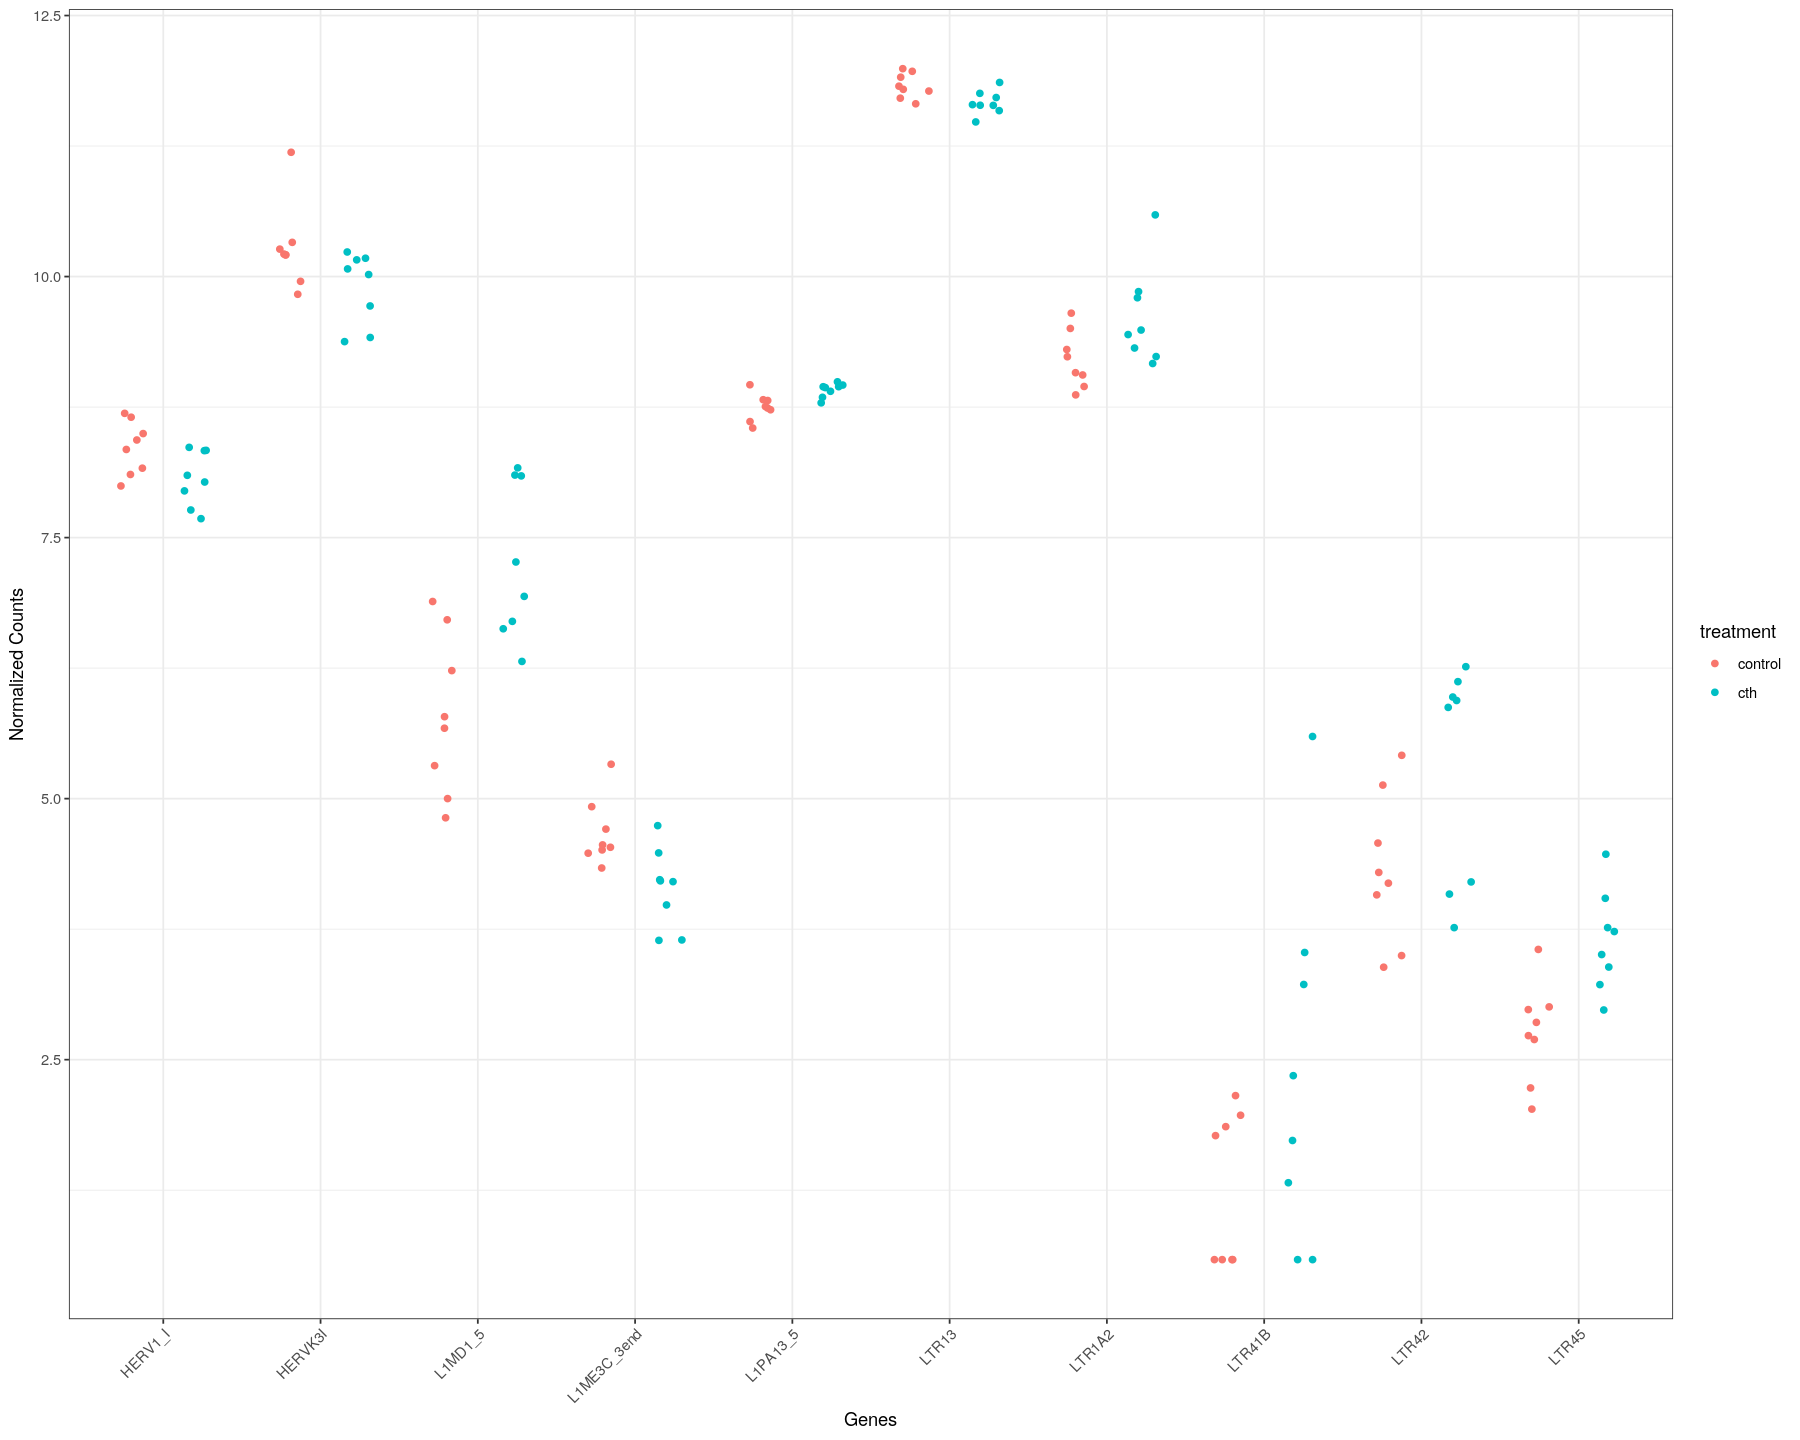

In [245]:
# Plot selected genes on a wide format
DEGreport::degPlotWide(counts = ddsSE, 
                       genes = row.names(apeglm_res_ord)[1:10], 
                       group = "condition")

### Hypothesis testing: Likelihood ratio test (LRT)

In [251]:
# The p-values are determined solely by the difference 
# in deviance between the ‘full’ and ‘reduced’ model formula 
# (not log2 fold changes)
dds_lrt <- DESeq(ddsSE, test="LRT", reduced = ~ 1)

using pre-existing normalization factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [253]:
# Extract results
res_LRT <- DESeq2::results(dds_lrt)

In [259]:
res_LRT$id <- rownames(res_LRT)

In [260]:
res_LRT_tb <- res_LRT %>% data.frame() %>% as_tibble()

In [262]:
res_LRT_tb_ord <- res_LRT_tb[order(res_LRT_tb$padj, 
                                   decreasing = FALSE),]

In [263]:
head(res_LRT_tb_ord)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
117.09528,1.4880554,0.37559097,15.157055,0.00009892796,0.05718036,L1MD1_5
31950.22475,0.1426757,0.06619912,4.643026,0.03117998148,0.83394664,AluSc
2851.52647,0.1511029,0.06980300,4.684303,0.03043940561,0.83394664,AluSq4
25858.40144,0.1437255,0.06816834,4.443525,0.03503383499,0.83394664,AluYa4
42.92319,-0.5808665,0.31203505,3.440610,0.06361221903,0.83394664,AluYf5
11537.56635,0.1161722,0.06297929,3.401606,0.06513298602,0.83394664,AluYi6


# TXIMPORT

In [10]:
salmon_samples <- read.table(file.path("SALMONTE_IN", 
                                       "salmonTE_samples.txt"), 
                             header = FALSE)
files <- file.path("SALMONTE_IN", 
                   paste0(salmon_samples$V1, 
                          "/",  
                          "quant.sf"))
condition = factor(rep(c('C','T'), 
                       each = 8))
as.vector(salmon_samples$V1)

[1] "RNA01" "RNA02" "RNA03" "RNA04" "RNA05" "RNA06" "RNA07" "RNA08" "RNA09"
[10] "RNA10" "RNA11" "RNA12" "RNA13" "RNA14" "RNA15" "RNA16"

In [11]:
files

[1] "SALMONTE_IN/RNA01/quant.sf" "SALMONTE_IN/RNA02/quant.sf"
 [3] "SALMONTE_IN/RNA03/quant.sf" "SALMONTE_IN/RNA04/quant.sf"
 [5] "SALMONTE_IN/RNA05/quant.sf" "SALMONTE_IN/RNA06/quant.sf"
 [7] "SALMONTE_IN/RNA07/quant.sf" "SALMONTE_IN/RNA08/quant.sf"
 [9] "SALMONTE_IN/RNA09/quant.sf" "SALMONTE_IN/RNA10/quant.sf"
[11] "SALMONTE_IN/RNA11/quant.sf" "SALMONTE_IN/RNA12/quant.sf"
[13] "SALMONTE_IN/RNA13/quant.sf" "SALMONTE_IN/RNA14/quant.sf"
[15] "SALMONTE_IN/RNA15/quant.sf" "SALMONTE_IN/RNA16/quant.sf"

In [12]:
txi = tximport::tximport(files,
                         type = "salmon",
                         txOut=TRUE, 
                         countsFromAbundance = "lengthScaledTPM")

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 




In [35]:
cols = c('0286', '1567', '0842', '1208',
           '0271', '1215', '1152', '0462',
           '0384', '0627', '0871', '0414',
           '0820', '0208', '1335', '1727')

In [36]:
# Rename columns with sample names
colnames(txi$counts) <- cols
colnames(txi$abundance) <- cols
colnames(txi$length) <- cols

In [94]:
# Rename columns with sample names
colnames(txi$counts) = as.vector(salmon_samples$V1)
colnames(txi$abundance) = as.vector(salmon_samples$V1)
colnames(txi$length) = as.vector(salmon_samples$V1)

In [37]:
head(txi$counts)

,0286,1567,0842,1208,0271,1215,1152,0462,0384,0627,0871,0414,0820,0208,1335,1727
ALU,3226.3756,3669.7148,2315.9159,3051.6655,2931.3970,3024.8494,4960.6004,3941.40688,4056.5073,3204.7109,1402.08082,3438.569,2393.640,2620.6443,2594.0020,2438.004
AluJb,11604.7988,9999.7086,8767.9576,12203.7934,10774.8263,11880.6386,18877.3705,10539.18715,15368.1595,12976.6117,4141.58373,13107.480,11054.145,10259.9617,9678.5824,8465.145
AluJo,1637.7511,123.0224,1147.8827,1643.6965,1288.2359,1421.5684,2554.2640,60.15723,1805.0810,1439.0537,68.08712,1786.732,1346.820,1224.6091,1163.2983,813.117
AluJr,611.3209,552.8991,450.6654,538.1211,536.9599,556.4189,743.4349,326.61129,602.4474,571.9772,209.38781,544.436,584.873,477.1999,384.6113,441.820
AluJr4,2975.0654,2449.7202,2288.7335,2877.1873,3069.8238,2941.5734,5392.2102,2748.79680,3570.6157,3382.9548,1041.85291,3147.153,2651.093,2596.9897,2526.4985,2016.538
AluSc,32280.1791,31041.8549,27070.7661,35086.9593,31362.5790,33196.5016,54644.1315,28276.25218,43297.8933,38909.4515,14284.99757,37438.059,34712.947,29960.5814,28813.9183,26743.405


In [38]:
# round counts
round_counts <- txi$counts %>% round() %>% data.frame()

In [39]:
head(round_counts)

,X0286,X1567,X0842,X1208,X0271,X1215,X1152,X0462,X0384,X0627,X0871,X0414,X0820,X0208,X1335,X1727
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALU,3226,3670,2316,3052,2931,3025,4961,3941,4057,3205,1402,3439,2394,2621,2594,2438
AluJb,11605,10000,8768,12204,10775,11881,18877,10539,15368,12977,4142,13107,11054,10260,9679,8465
AluJo,1638,123,1148,1644,1288,1422,2554,60,1805,1439,68,1787,1347,1225,1163,813
AluJr,611,553,451,538,537,556,743,327,602,572,209,544,585,477,385,442
AluJr4,2975,2450,2289,2877,3070,2942,5392,2749,3571,3383,1042,3147,2651,2597,2526,2017
AluSc,32280,31042,27071,35087,31363,33197,54644,28276,43298,38909,14285,37438,34713,29961,28814,26743


In [40]:
# design = table of samples corresponding to conditions
condition = factor(rep(c('C','T'), 
                       each = 8))
samples <- data.frame(row.names=as.vector(cols), 
                      condition=condition)
# importing salmon count data into DESeq
suppressMessages(dds_salmon <- DESeqDataSetFromTximport(txi, 
                                                        samples, 
                                                        ~condition))
# Filter null or ultra-low abundance genes
keep <- rowSums(counts(dds_salmon)) > 1
dds_salmon <- dds_salmon[keep,]
dds_salmon

class: DESeqDataSet 
dim: 596 16 
metadata(1): version
assays(1): counts
rownames(596): ALU AluJb ... X5B_LINE X6B_LINE
rowData names(0):
colnames(16): 0286 1567 ... 1335 1727
colData names(1): condition

In [41]:
dds_salmon <- estimateSizeFactors(dds_salmon)

In [42]:
sizeFactors(dds_salmon)

0286      1567      0842      1208      0271      1215      1152      0462 
1.2605838 0.9810997 0.9233384 1.1755129 0.9330038 1.0549517 1.6642496 1.0030966 
     0384      0627      0871      0414      0820      0208      1335      1727 
1.4017750 1.1162683 0.3818604 1.0971158 1.0142381 1.0019576 0.9104228 0.7680123

In [43]:
normalized_counts <- counts(dds_salmon, normalized=TRUE)

In [44]:
# export count table
write.csv(normalized_counts, 
            file = "SALMONTE_RES/SalmonTE_CountTable_PATIENTS.txt", 
            row.names = T, 
            quote = F)

In [45]:
suppressMessages(dds_salmon <- DESeq(dds_salmon))

In [46]:
colnames(mcols(dds_salmon))

[1] "baseMean"                       "baseVar"                       
 [3] "allZero"                        "dispGeneEst"                   
 [5] "dispGeneIter"                   "dispFit"                       
 [7] "dispersion"                     "dispIter"                      
 [9] "dispOutlier"                    "dispMAP"                       
[11] "Intercept"                      "condition_T_vs_C"              
[13] "SE_Intercept"                   "SE_condition_T_vs_C"           
[15] "WaldStatistic_Intercept"        "WaldStatistic_condition_T_vs_C"
[17] "WaldPvalue_Intercept"           "WaldPvalue_condition_T_vs_C"   
[19] "betaConv"                       "betaIter"                      
[21] "deviance"                       "maxCooks"                      
[23] "replace"

In [47]:
# raw counts
colSums(counts(dds_salmon))

0286    1567    0842    1208    0271    1215    1152    0462    0384    0627 
1536903 1489449 1360274 1763220 1315438 1383802 2118378 1196868 2179251 1667785 
   0871    0414    0820    0208    1335    1727 
 592444 1263817 1542481 1339887 1110121 1192397

In [48]:
# normalized counts
colSums(counts(dds_salmon, normalized=T))

0286    1567    0842    1208    0271    1215    1152    0462    0384    0627 
1219199 1518142 1473213 1499958 1409896 1311721 1272873 1193173 1554637 1494072 
   0871    0414    0820    0208    1335    1727 
1551468 1151945 1520827 1337269 1219347 1552575

In [49]:
# Following calculation (ntd, vsd, rld) only for
# plot PCA and heirarchical clustering figures for quality assessment

In [50]:
# Normalized Counts Transformation (NCT)
ntd <- normTransform(dds_salmon)

In [51]:
# variance stabilizing transformation (VST) 
# for negative binomial data with a dispersion-mean trend
# blind=TRUE -> unbiased to sample condition information
vsd <- varianceStabilizingTransformation (dds_salmon, blind = TRUE)

In [52]:
# regularized-logarithm transformation (RLOG)
# -> moderate the variance across the mean
rld <- rlog(dds_salmon, blind = TRUE)

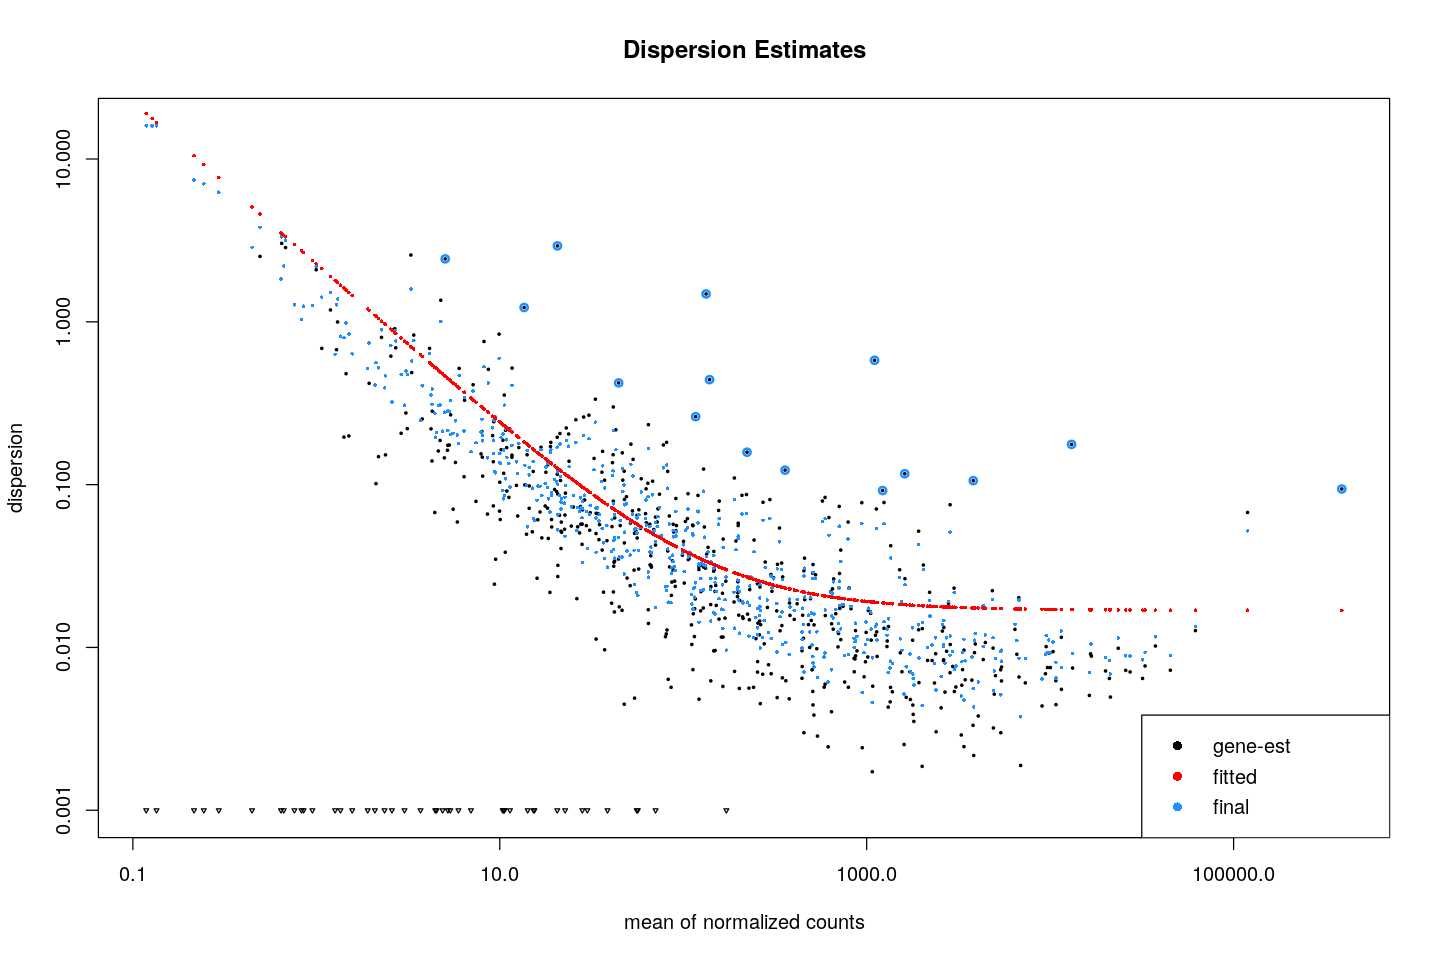

In [133]:
options(repr.plot.width=12, 
        repr.plot.height=8)
plotDispEsts(dds_salmon, 
             ymin=0.001, 
             cex=0.4, 
             main="Dispersion Estimates")

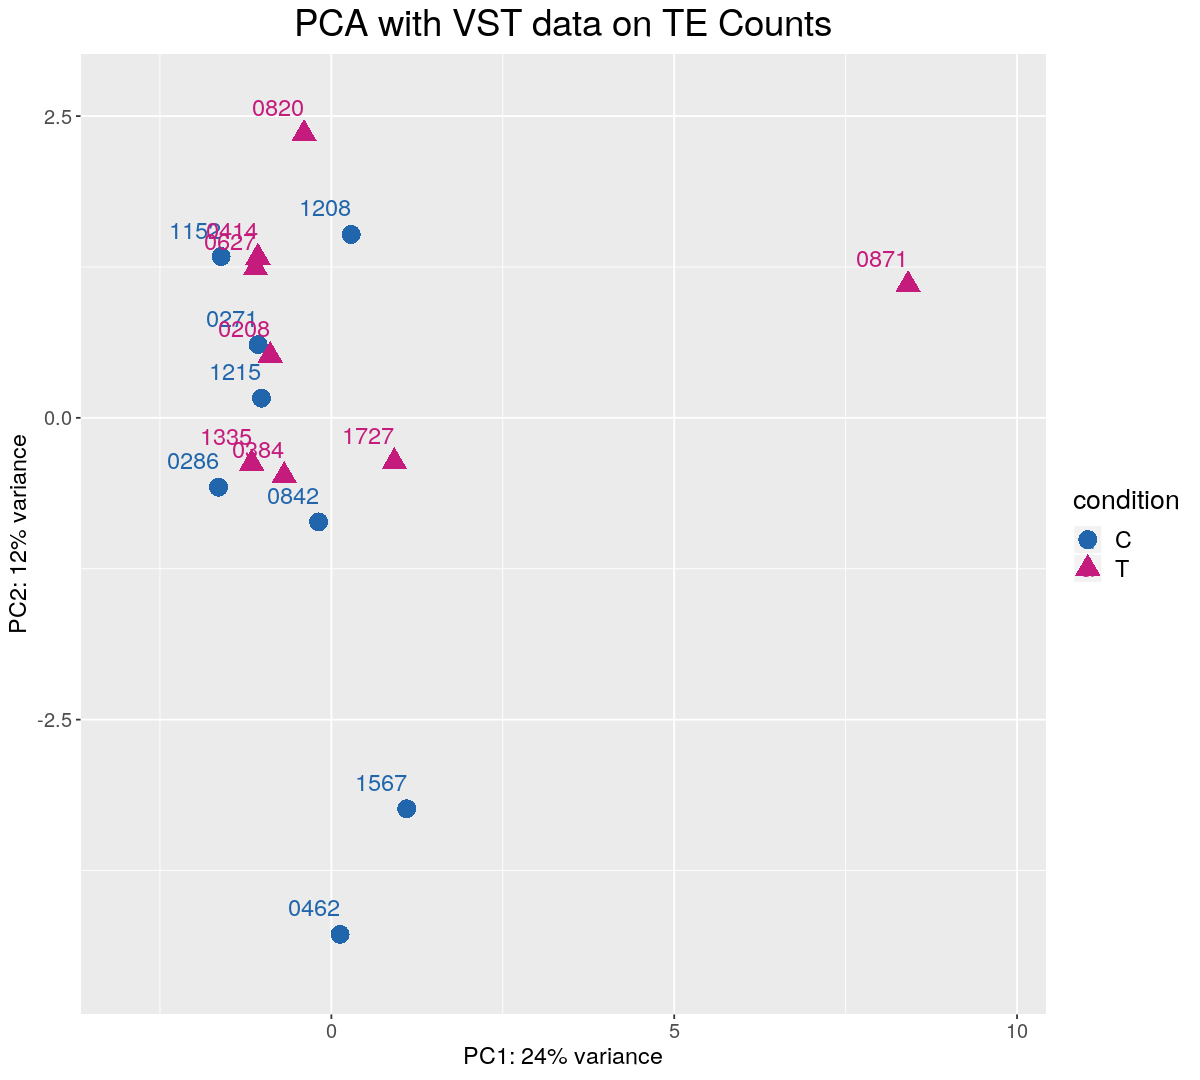

In [55]:
pcaData <- DESeq2::plotPCA(vsd, intgroup = colnames(colData(vsd)[1]), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(pcaData, aes(x = PC1, y = PC2, color=condition, shape=condition)) +
geom_point(size =5) +
geom_text(aes(label=name),hjust=1, vjust=-1, cex=5) +
xlab(paste0("PC1: ", percentVar[1], "% variance")) +
ylab(paste0("PC2: ", percentVar[2], "% variance")) +
scale_x_continuous(expand = c(0.2, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
ggtitle("PCA with VST data on TE Counts") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))

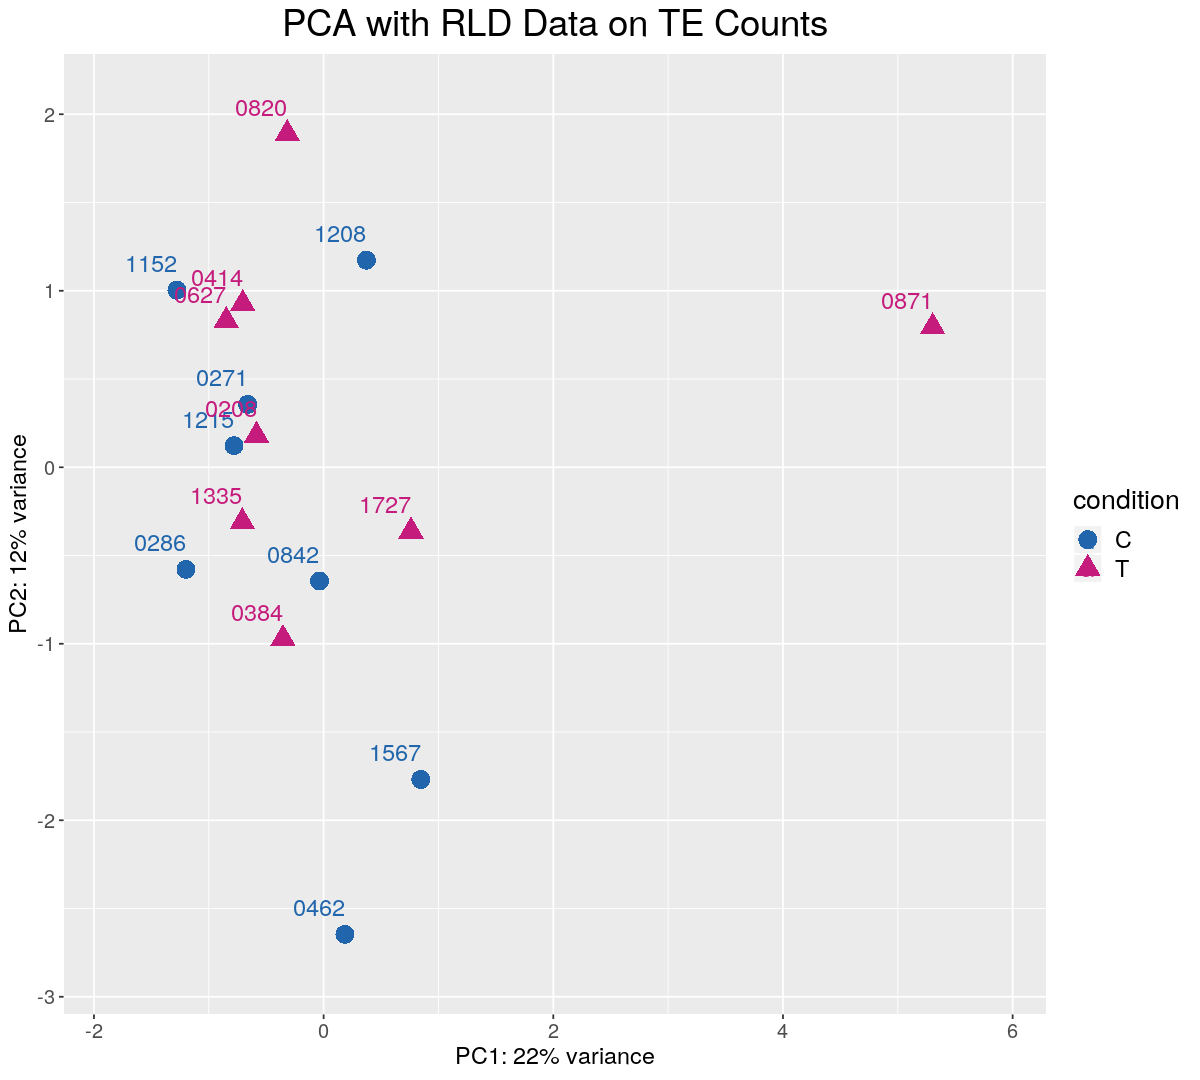

In [57]:
# RLOG PCA
pcaData <- DESeq2::plotPCA(rld, intgroup = colnames(colData(rld)[1]), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(pcaData, aes(x = PC1, y = PC2, color=condition, shape=condition)) +
geom_point(size =5) +
geom_text(aes(label=name),hjust=1, vjust=-1, cex=5) +
xlab(paste0("PC1: ", percentVar[1], "% variance")) +
ylab(paste0("PC2: ", percentVar[2], "% variance")) +
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
ggtitle("PCA with RLD Data on TE Counts") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("SALMONTE_RES/SalmonTE_TXIMETA_PCA_RLD_TE.png", width=10, height=9)

In [69]:
# subset of the 20 most highly variable genes from VST data
#topVarTx <- head(which(res_se$padj < 0.8),decreasing = FALSE, 20)
topVarTx <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 20)
mat  <- assay(vsd)[topVarTx,]
#mat  <- mat - rowMeans(mat)
mat

,0286,1567,0842,1208,0271,1215,1152,0462,0384,0627,0871,0414,0820,0208,1335,1727
AluJo,10.438704,7.682971,10.379130,10.538338,10.520703,10.488338,10.664763,7.074395,10.426431,10.427966,8.023896,10.746190,10.468255,10.356495,10.415660,10.163383
FLAM,13.110940,14.350807,14.539825,13.774315,13.495417,13.375800,13.092804,12.998356,13.820724,13.253119,17.094957,13.067865,13.911461,13.236470,13.127039,14.604049
AluSx1,7.951856,5.491470,7.218694,8.438823,7.431011,7.374472,8.422283,5.491470,7.117856,7.772681,8.377967,8.308017,8.594112,7.390031,7.157906,6.906671
AluSx,7.989566,7.340638,7.195383,7.693135,8.077070,7.623930,7.987847,8.124725,7.785454,7.760281,5.491470,8.445006,8.064897,7.805080,7.783220,7.414101
L1MD1_5,7.507646,6.948798,6.990086,6.570699,7.222101,6.773347,7.616410,6.637399,8.470214,8.532488,7.281006,7.645162,7.460192,8.478850,7.499375,7.868239
AluYd2,5.491470,5.491470,5.491470,7.353312,6.578949,5.491470,6.360529,6.196707,6.688953,6.097748,5.491470,6.835143,6.280725,7.122303,6.263137,6.329846
L2,8.365256,8.502452,8.533063,8.588766,8.491073,8.477138,8.504652,8.298435,8.346940,8.355195,10.517731,8.648233,8.314134,8.458192,8.636376,8.514466
HARLEQUIN,11.649125,12.158691,11.841529,11.627415,11.412506,11.456718,10.869191,12.291839,11.906239,11.581814,13.002334,12.124620,11.601471,11.889576,11.898369,12.311461
FAM,17.956163,18.951976,18.917405,19.075888,18.552294,18.441960,18.142450,18.095536,19.014509,18.584985,18.619901,17.441777,18.707512,18.350864,17.994580,19.134528
HERVE_a,10.790017,10.881012,10.411648,10.581465,11.087366,10.924810,9.756830,10.962216,11.676476,10.446628,11.018213,10.319531,10.127345,10.630967,10.521969,10.548298


In [66]:
rownames(colData(ddsSE)) <- cols

In [67]:
df <- as.data.frame(colData(ddsSE)['condition'])

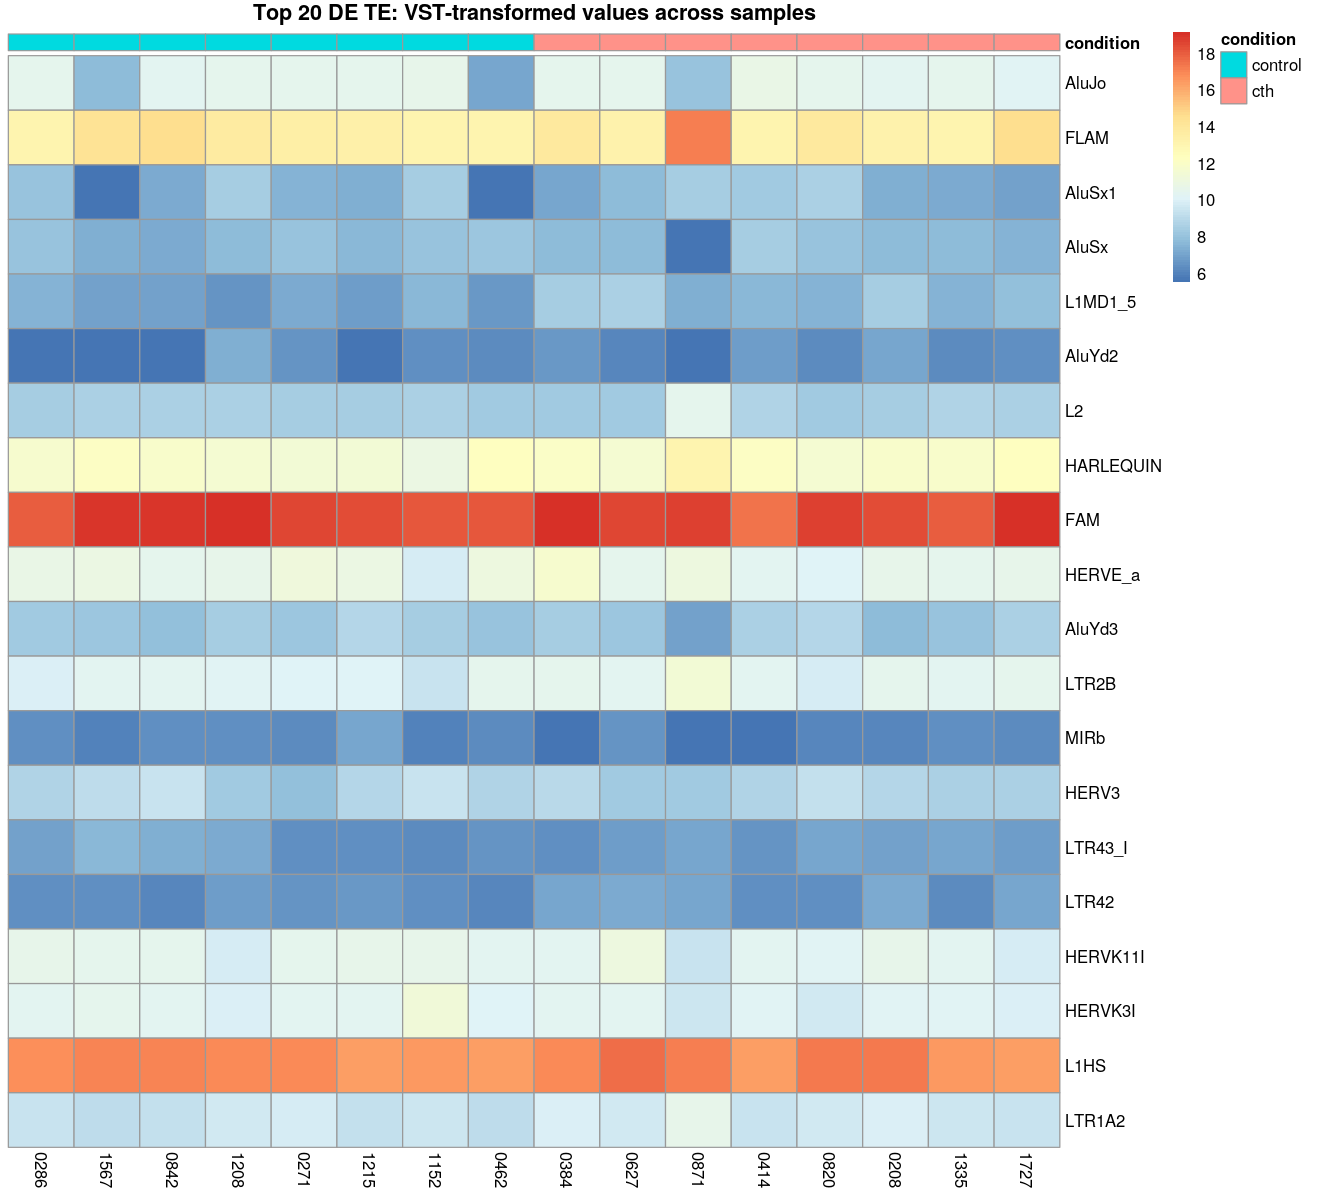

In [71]:
options(repr.plot.width=11, repr.plot.height=10)
pm = pheatmap(mat, 
              main="Top 20 DE TE: VST-transformed values across samples",
              cluster_rows=FALSE,
              cluster_cols=FALSE,
              annotation_col=df)
save_pheatmap_png(pm, "SALMONTE_RES/SalmonTE_TXIMETA_heatmap_topDE_TE_VST.png")

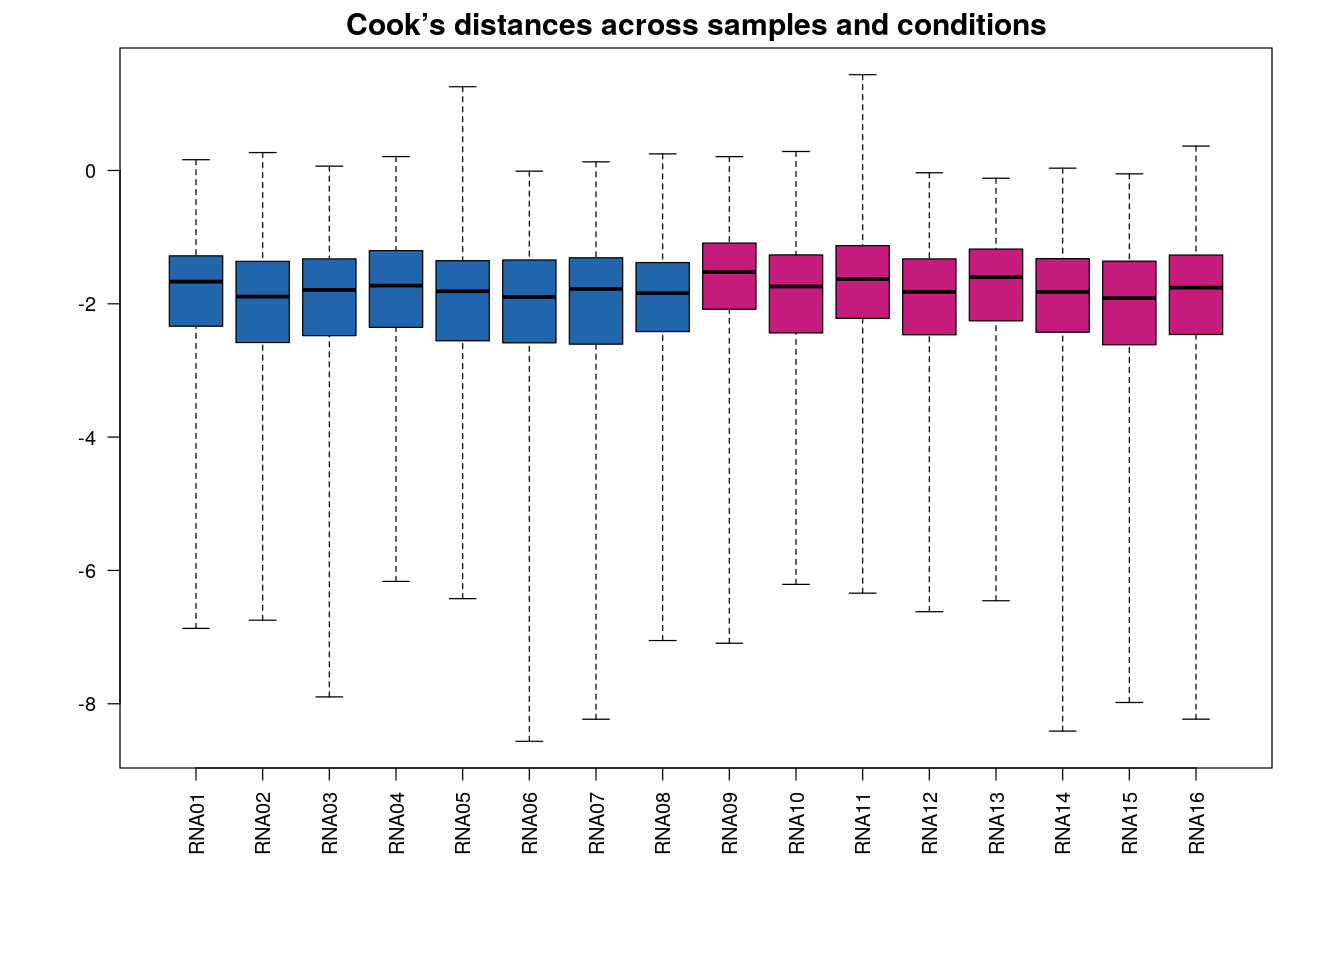

In [44]:
col <- rep(c(brewer.pal(8, "RdBu")[8], 
             brewer.pal(8, "PiYG")[1]), 
             each = 8)
options(repr.plot.width=11, 
        repr.plot.height=8)
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds_salmon)[["cooks"]]), 
        range=0, 
        las=2, 
        col=col,
        main="Cook’s distances across samples and conditions",
        cex.main=1.5)

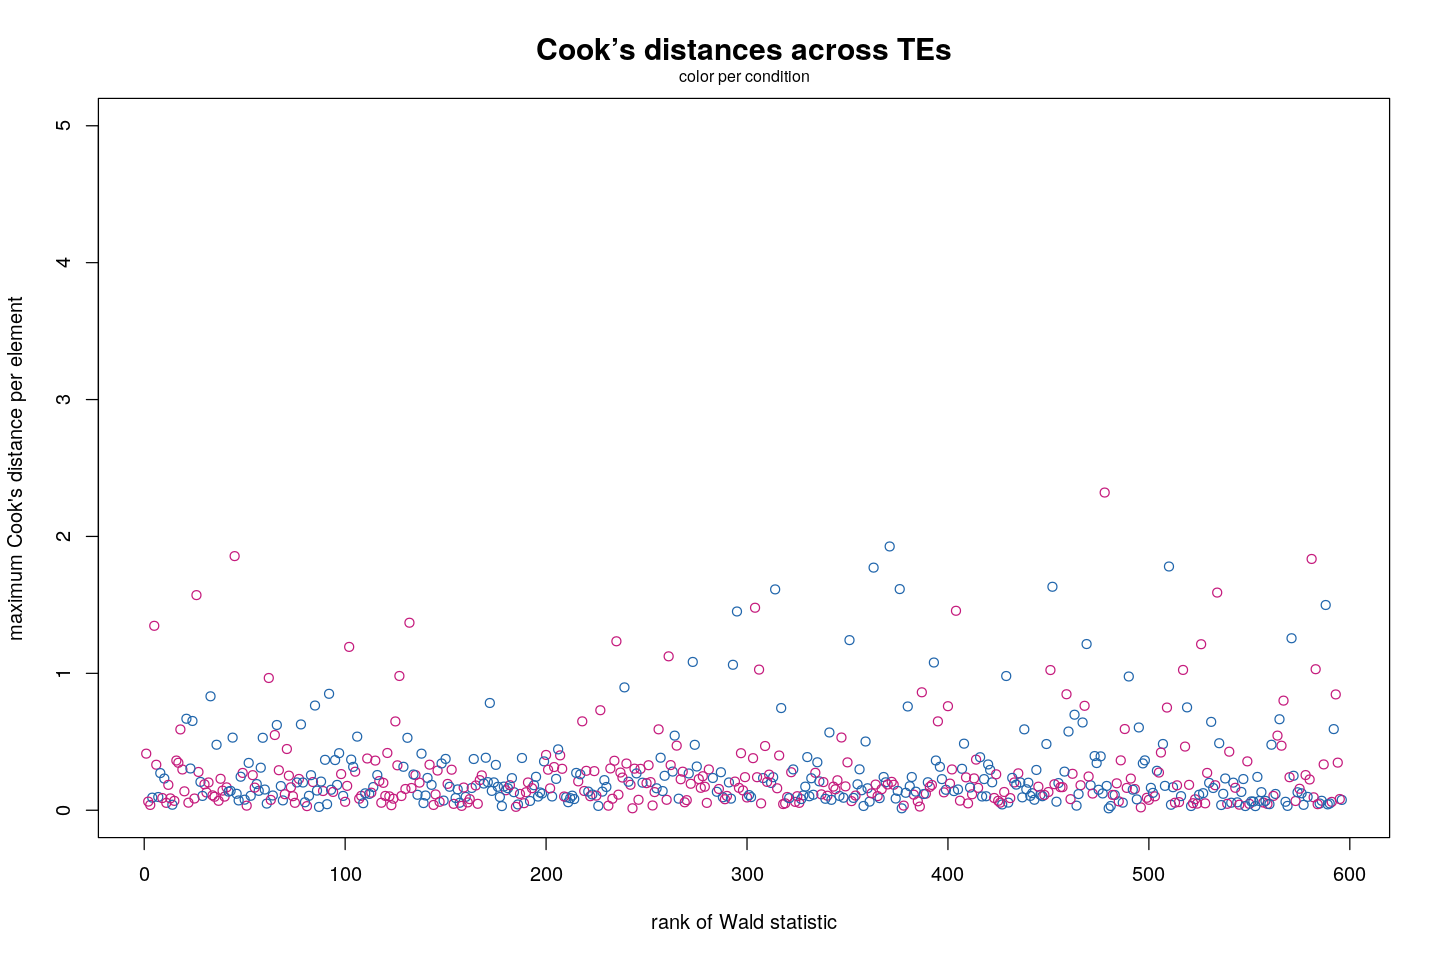

In [46]:
col <- rep(c(brewer.pal(8, "RdBu")[8], 
             brewer.pal(8, "PiYG")[1]), 
             each = 8)
options(repr.plot.width=12, repr.plot.height=8)
W <- res_salmon$stat
maxCooks <- apply(assays(dds_salmon)[["cooks"]],1,max)
idx <- !is.na(W)
plot(rank(W[idx]), 
     maxCooks[idx], 
     xlab="rank of Wald statistic", 
     ylab="maximum Cook's distance per element",
     ylim=c(0,5), 
     cex=1, 
     col=col,
     main="Cook’s distances across TEs",
     cex.main=1.5)
m <- ncol(dds_salmon)
p <- 3
abline(h=qf(.99, p, m - p))
subtitle ="color per condition"
mtext(line=0.5, 
      adj=0.5, 
      cex=0.8, 
      subtitle)

## RESULTS

In [119]:
resultsNames(dds_salmon)

[1] "Intercept"        "condition_T_vs_C"

In [135]:
res_salmon <- DESeq2::results(dds_salmon, name="condition_T_vs_C")

In [136]:
class(res_salmon)

[1] "DESeqResults"
attr(,"package")
[1] "DESeq2"

In [137]:
mcols(res_salmon, use.names=T)

DataFrame with 6 rows and 2 columns
                       type                               description
                <character>                               <character>
baseMean       intermediate mean of normalized counts for all samples
log2FoldChange      results  log2 fold change (MLE): condition T vs C
lfcSE               results          standard error: condition T vs C
stat                results          Wald statistic: condition T vs C
pvalue              results       Wald test p-value: condition T vs C
padj                results                      BH adjusted p-values

In [146]:
# shrinking fold2change with apeglm
apeglm_res <- lfcShrink(dds_salmon, 
                        coef="condition_T_vs_C",
                        type='apeglm',
                        res=res_salmon)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



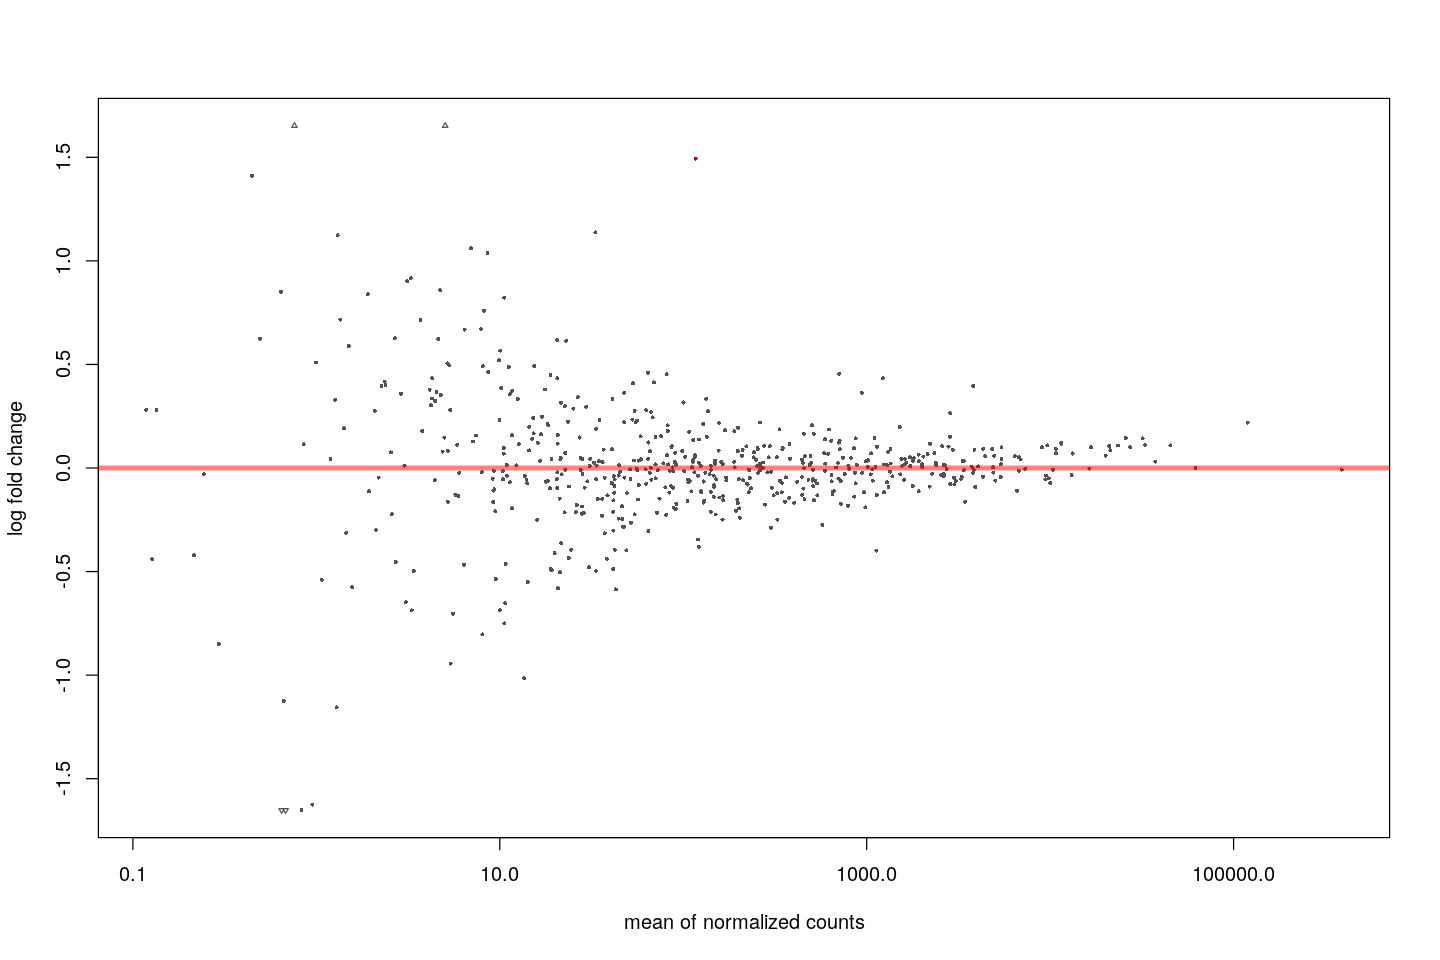

In [151]:
# unshrunken
plotMA(res_salmon)

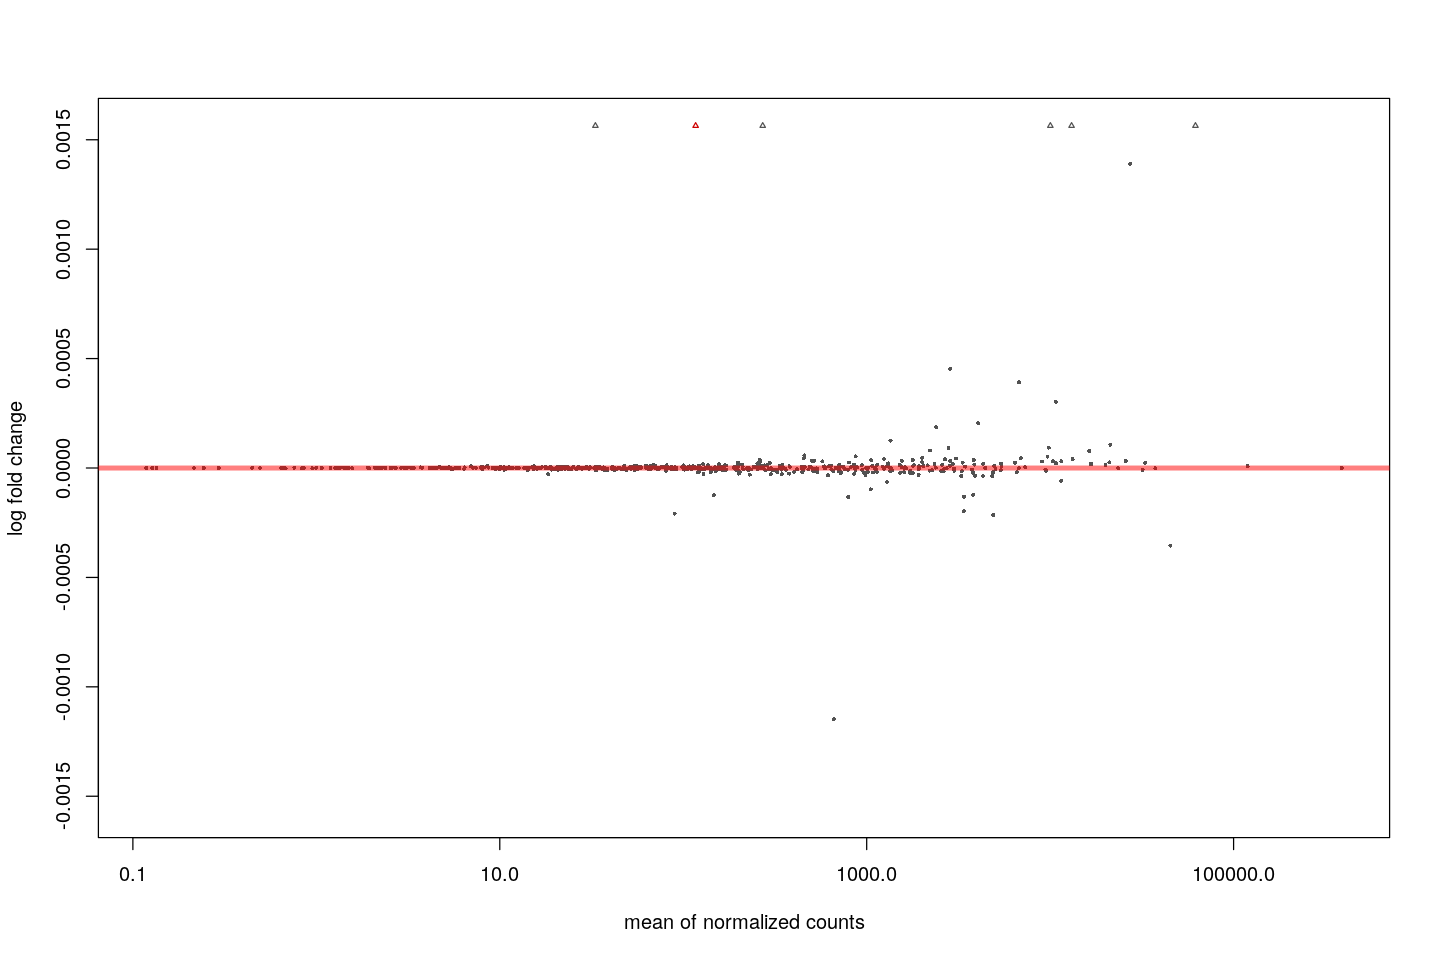

In [150]:
# apeglm shrunken
plotMA(apeglm_res)

In [47]:
table(res_salmon$padj < 0.1)


FALSE  TRUE 
  594     1 

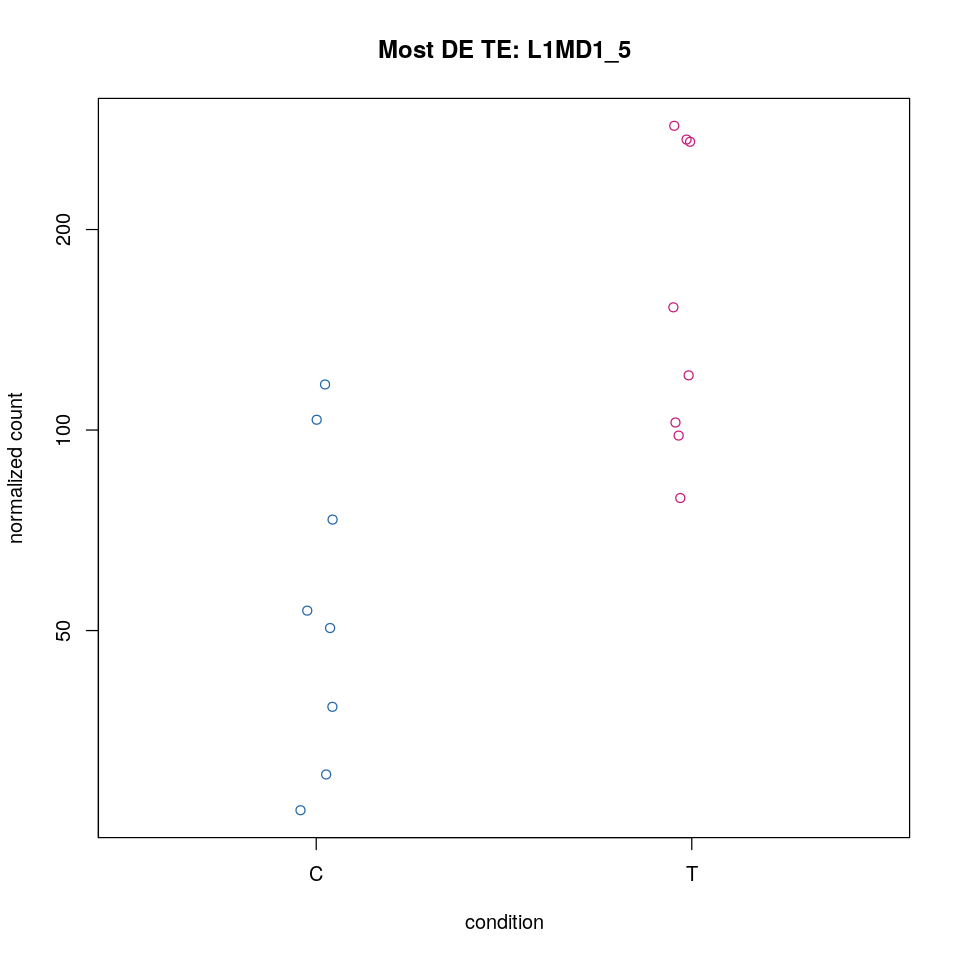

In [49]:
col <- rep(c(brewer.pal(8, "RdBu")[8], 
             brewer.pal(8, "PiYG")[1]), 
           each = 8)
options(repr.plot.width=8, 
        repr.plot.height=8)
topGene <- rownames(dds_salmon)[which.min(res_salmon$padj)]
plotCounts(dds_salmon, 
           gene = topGene, 
           intgroup=c("condition"), 
           col=col,
           main=paste0("Most DE TE: ", topGene),
           xlab="condition")

In [51]:
select <- order(rowMeans(counts(dds_salmon,normalized=TRUE)), decreasing=TRUE)

In [53]:
df_select <- dds_salmon[order(rowMeans(counts(dds_salmon,normalized=TRUE)), decreasing=TRUE)]

In [58]:
df_counts <- as.data.frame(counts(df_select))

In [59]:
# export count table
write.csv(df_counts, 
            file = "SALMONTE_RES/SalmonTE_CountTable_2.txt", 
            row.names = T, 
            quote = F)